# Глубокое обучение


## Тема 2. Вариационные автокодировщики 👖
 

Импортируем необходимые библиотеки:

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"            # "jax" "tensorflow" "torch"
#os.environ["ENABLE_PJRT_COMPATIBILITY"] = "1"   # added for jax
#os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1" # added for torch

In [2]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

In [3]:
import keras
from keras import models,layers,datasets,callbacks
keras.__version__, keras.backend.backend()

('3.9.2', 'tensorflow')

### Автокодировщики

Нейронные сети обычно используются при обучении с учителем (supervised learning). Это означает, что для каждой точки обучающего набора данных $\mathbf{x}_{i}$ имеется отклик $y_{i}$. Во время обучения модель нейронной сети изучает взаимосвязь между входными данными и откликами. 

Теперь предположим, что имеются только немаркированные данные, то есть у нас есть только обучающий набор данных $\mathbf{D}$, состоящий из $n$ точек $\mathbf{x}_{i}\in\mathbb{R}^{d}$, где $i=1,...,n$. 

Автокодировщики (автоэнкодеры, autoencoders) были введены Румелхартом, Хинтоном и Уильямсом в 1986 году с целью _научиться восстанавливать входные наблюдения $\mathbf{x}_{i}$ с минимально возможной ошибкой_. 

__Автокодировщик__ — это тип алгоритма, основной целью которого является обучение _информативному_ представлению данных, которое можно использовать для различных приложений, путем обучения достаточно хорошей реконструкции набора входных данных.

Чтобы лучше понять автокодировщики, обратимся к их типичной архитектуре, представленной ниже.

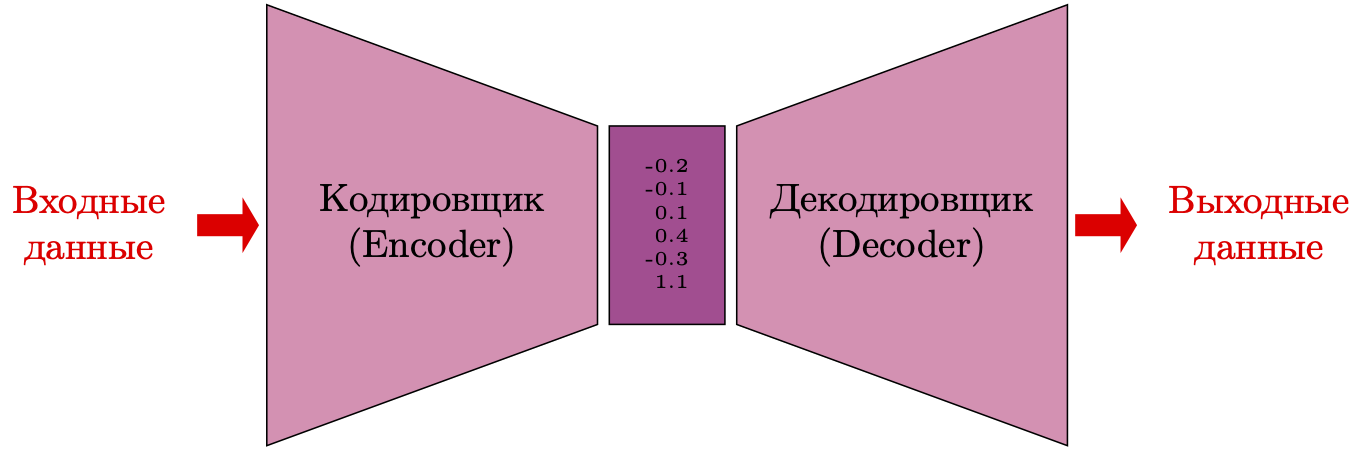

Основными компонентами __автокодировщика__ являются: 
* __кодировщик__ 
* __латентное пространство__  
* __декодер__. 

Кодировщик (энкодер) и декодер — это функции, обычно представленные нейронными сетями, а латентное пространство – это представление скрытых (латентных) признаков, которое является выходом кодировщика и входом декодера. Вообще говоря, требуется, чтобы автокодировщик достаточно хорошо реконструировал входные данные, при этом он должен создавать скрытое представление, которое является полезным и содержательным.

Обозначим энкодер и декодер в составе автокодировщика через $f$ (энкодер) и $g$ (декодер). Энкодер $f$ переводит входной сигнал $x$ в его представление (код) $z$: 

$$z=f\left(x\right),$$ 

а декодер $g$ восстанавливает сигнал $x$ по его коду $z$: 

$$x=g\left(z\right).$$

Автокодировщик, изменяя функции $f$ и $g$, стремится обучиться тождественной функции $x=g\left(f\left(x\right)\right)$, минимизируя какой-либо функционал ошибки $L\left(x,g\left(f\left(x\right)\right)\right)$.

При этом семейства функций для энкодера $f$ и декодера $g$ каким-либо образом ограничивают, чтобы автоэнкодер был вынужден отбирать наиболее важные свойства входных данных.

### Метод главных компонент

__Метод главных компонент__ (Principal Component Analysis, PCA) – это метод, позволяющий найти пространственный базис, который наилучшим образом отражает дисперсию в наборе данных.

Допустим, что данные уже центрированы путем вычитания средних значений: $\mathbf{x}\leftarrow\mathbf{x}-\mathbb{E}\left[\mathbf{x}\right]$.

Первая главная компонента (направление с максимальной дисперсией) $\mathbf{w}_{1}^{*}$ находится путем максимизации дисперсии данных, умноженных на вектор $\mathbf{w}_{1}$ единичной длины:

$$y_{1}=\mathbf{x}^{T}\mathbf{w}_{1},\,\left\Vert \mathbf{w}_{1}\right\Vert =1\Rightarrow\mathbb{E}\left[y_{1}^{2}\right]=\mathbb{E}\left[\mathbf{w}_{1}^{T}\mathbf{x}\mathbf{x}^{T}\mathbf{w}_{1}\right]=\mathbf{w}_{1}^{T}\mathbb{E}\left[\mathbf{x}\mathbf{x}^{T}\right]\mathbf{w}_{1}=\mathbf{w}_{1}^{T}\boldsymbol{\Sigma}_{\mathbf{x}}\mathbf{w}_{1}$$

Отсюда получаем, что решение $\mathbf{w}_{1}^{*}$ задается собственным вектором ковариационной матрицы $\boldsymbol{\Sigma}_{\mathbf{x}}$, соответствующим наибольшему собственному значению матрицы $\boldsymbol{\Sigma}_{\mathbf{x}}$:

$$\mathbf{w}_{1}^{*}=\underset{\mathbf{w}_{1}:\,\left\Vert \mathbf{w}_{1}\right\Vert =1}{\arg\max}\mathbf{w}_{1}^{T}\boldsymbol{\Sigma}_{\mathbf{x}}\mathbf{w}_{1}$$

Вторая главная компонента находится как направление с максимальной дисперсией при условии ортогональности направлению первой главной компоненты (и т.д.). 

Пусть построено $m$-мерное подпространство, порожденное ортонормальным базисом из $m$ главных компонент $\mathbf{w}_{1},...,\mathbf{w}_{m}$:

$$\mathbf{W}=\left[\begin{array}{ccc}
\mathbf{w}_{1} & \ldots & \mathbf{w}_{m}\end{array}\right],\,\mathbf{W}^{T}\mathbf{W}=\mathbf{I}_{m}$$

Можно спроектировать $d$-мерные векторы данных $\mathbf{x}$ на это подпространство: 

$$\mathbf{z}=\mathbf{W}^{T}\mathbf{x}$$

Реконструкция $\mathbf{x}$, которая остается внутри $m$-мерного подпространства, порожденного $\mathbf{W}$, равна

$$\hat{\mathbf{x}}=\mathbf{W}\mathbf{z}=\mathbf{W}\mathbf{W}^{T}\mathbf{x}$$

Поэтому мы находим такую матрицу $\mathbf{W}$, что среднеквадратическая ошибка между исходными данными $\mathbf{x}$ и реконструированным вектором $\hat{\mathbf{x}}$ сведена к минимуму:

$$\mathbf{W}_{PCA}=\underset{\mathbf{W}:\,\mathbf{W}^{T}\mathbf{W}=\mathbf{I}_{m}}{\arg\min}\mathbb{E}\left[\left\Vert x-\underbrace{\mathbf{W}\mathbf{W}^{T}\mathbf{x}}_{\hat{\mathbf{x}}}\right\Vert ^{2}\right],$$

поэтому метод PCA может быть интерпретирован как сжатие с минимальной среднеквадратичной ошибкой (MSE).

### Метод PCA как автокодировщик со сжатием

Метод PCA может рассматриваться как автокодировщик. Будем обучать отображение из $\mathbf{x}$ в $\hat{\mathbf{x}}$:

$$\hat{\mathbf{x}}=g\left(f\left(\mathbf{x}\right)\right),$$

где:

* $f\left(\mathbf{x}\right)=\mathbf{W}_{f}\,\mathbf{x}+\mathbf{b}_{f}$ – линейный кодировщик

* $g\left(\mathbf{z}\right)=\mathbf{W}_{g}\,\mathbf{z}+\mathbf{b}_{g}$ – линейный декодер

* $\mathcal{L}\left(\mathbf{x}\right)=\mathbb{E}\left[\left\Vert \mathbf{x}-g\left(f\left(\mathbf{x}\right)\right)\right\Vert ^{2}\right]$ – функция потерь

Если мы никак не ограничиваем линейные функции $f$ и $g$, то мы рискуем изучить тривиальное тождественное отображение:

$$\hat{\mathbf{x}}=g\left(f\left(\mathbf{x}\right)\right)=\mathbf{W}_{g}\,\left(\mathbf{W}_{f}\,\mathbf{x}+\mathbf{b}_{f}\right)+\mathbf{b}_{g}=\left(\mathbf{W}_{g}\,\mathbf{W}_{f}\right)\,\mathbf{x}+\left(\mathbf{W}_{g}\,\mathbf{b}_{f}+\mathbf{b}_{g}\right)=\mathbf{x}$$

$$\Longrightarrow\mathbf{W}_{g}=\mathbf{W}_{f}^{-1},\,\mathbf{b}_{g}=-\mathbf{W}_{g}\,\mathbf{b}_{f}$$

Если размерность вектора $\mathbf{z}$ меньше размерности вектора $\mathbf{x}$, то автокодирование полезно, так как мы сжимаем данные. 

Таким образом, метод PCA может быть реализован с помощью автокодировщика со сжатием.

Как можно улучшить сжатие, чтобы получить меньшую ошибку реконструкции

$$\mathcal{L}\left(\mathbf{x}\right)=\mathbb{E}\left[\left\Vert \mathbf{x}-g\left(f\left(\mathbf{x}\right)\right)\right\Vert ^{2}\right]$$

со слоем сужения того же размера?

Мы можем использовать нелинейные кодировщик $f$ и декодер $g$ такие, что:

* и кодировщик, и декодер являются __глубокими нейронными сетями__ 

* критерием оптимизации является __среднеквадратическая ошибка реконструкции__:

$$\boldsymbol{\theta}_{f},\,\boldsymbol{\theta}_{g}=\underset{\boldsymbol{\theta}_{f},\,\boldsymbol{\theta}_{g}}{\arg\min}\mathbb{E}\left[\left\Vert \mathbf{x}-g\left(f\left(\mathbf{x};\boldsymbol{\theta}_{f}\right);\boldsymbol{\theta}_{g}\right)\right\Vert ^{2}\right]$$

* чтобы предотвратить изучение тривиальной (тождественной) функции $f$, мы используем латентное пространство $\mathbf{z}$ с меньшим количеством измерений (__слой сужения__).

Автокодировщик обучен восстанавливать изображение после того, как оно прошло через кодировщик и обратно через декодер. На первый взгляд это может показаться странным: зачем  восстанавливать набор изображений, которые у вас уже есть? Однако, как мы увидим, именно __пространство эмбеддинга__ (также называемое скрытым или __латентным пространством__) является весьма интересной частью автокодировщика, поскольку выборка из этого пространства позволит нам генерировать новые изображения.

Давайте сначала определим, что подразумевается под вложением (эмбеддингом). __Эмбеддинг__ $(\mathbf{z})$ представляет собой сжатие исходного изображения в скрытое пространство меньшей размерности. Идея состоит в том, что, выбрав любую точку в скрытом пространстве, мы можем генерировать новые изображения, пропуская эту точку через декодер, поскольку декодер научился преобразовывать точки в скрытом пространстве в жизнеспособные изображения.

### Пример автокодировщика для набора Fashion-MNIST

Рассмотрим в качестве примера создание и обучение автокодировщика на наборе данных  __Fashion-MNIST__.

Набор данных Fashion-MNIST — коллекция изображений предметов одежды в оттенках серого, каждое размером 28 × 28 пикселей.

In [14]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

#### Параметры <a name="parameters"></a>

В этом примере мы встроим изображения в двумерное скрытое пространство $\mathbb{R}^{2}$. Это поможет нам визуализировать скрытое пространство, поскольку можно легко построить точки в 2D (на плоскости). На практике скрытое пространство автокодировщика обычно имеет более двух измерений, чтобы иметь больше свободы для улавливания большего количества нюансов изображений.

In [16]:
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 100
BUFFER_SIZE = 1000
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 3

#### Подготовка данных <a name="prepare"></a>

In [17]:
# Load the data
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

Эти готовые изображения размером 28 × 28 в оттенках серого (значения пикселей от 0 до 255) нам необходимо предварительно обработать, чтобы гарантировать, что значения пикселей масштабируются от 0 до 1. Также дополним каждое изображение до размера 32 × 32 для удобства манипулирования формой тензора при его прохождении через нейронную сеть.

In [18]:
# Preprocess the data

def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

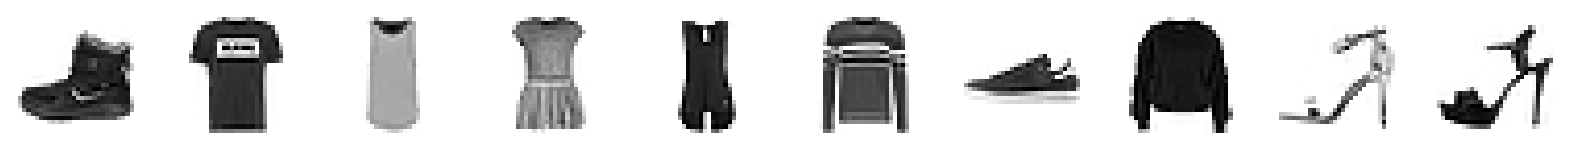

In [19]:
# Show some items of clothing from the training set
display(x_train)

In [20]:
x_train.shape

(60000, 32, 32, 1)

#### Построение автокодировщика <a name="build"></a>

В автокодировщике работа кодировщика состоит в том, чтобы взять входное изображение и сопоставить ему вектор эмбеддинга в скрытом пространстве. Чтобы добиться этого, мы сначала создаем входной слой для изображения и последовательно пропускаем его через три слоя `Conv2D`, каждый из которых фиксирует все более высокоуровневые признаки. Используется шаг 2, чтобы уменьшить вдвое размер выхода каждого слоя, одновременно увеличивая количество каналов. Последний сверточный слой сглаживается и соединяется с плотным слоем размера 2, который представляет наше двумерное скрытое пространство.

In [21]:
# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = x.shape[1:]  # the decoder will need this! K.int_shape(x)

x = layers.Flatten()(x)
encoder_output = layers.Dense(EMBEDDING_DIM, name="encoder_output")(x)

encoder = models.Model(encoder_input, encoder_output)
encoder.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,770 (378.01 KB)

 Trainable params: 96,770 (378.01 KB)

 Non-trainable params: 0 (0.00 B)

Декодер является зеркальным отражением кодировщика — вместо сверточных слоев используются сверточные транспонированные слои.

Стандартные сверточные слои позволяют нам уменьшить вдвое размер входного тензора в обоих измерениях (по высоте и ширине), установив параметр `strides = 2`.
Слой сверточного транспонирования использует тот же принцип, что и стандартный сверточный слой (пропускание фильтра по изображению), но отличается тем, что установка `strides = 2` удваивает размер входного тензора в обоих измерениях.

В Keras слой `Conv2DTranspose` позволяет нам выполнять операции сверточного транспонирования тензоров. Накладывая эти слои друг на друга, мы можем постепенно увеличивать размер каждого слоя, используя шаг 2, пока не вернемся к исходному размеру изображения 32 × 32.

In [22]:
# Decoder
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    CHANNELS,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

Чтобы одновременно обучать кодировщик и декодер, необходимо определить модель, которая будет представлять поток изображения через кодировщик и обратно через декодер. Здесь выходные данные автокодировщика — это просто выходные данные кодировщика после того, как они прошли через декодер.

In [23]:
# Autoencoder
autoencoder = models.Model(
    encoder_input, decoder(encoder_output)
)  # decoder(encoder_output)
autoencoder.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_6 (Functional)       │ (None, 32, 32, 1)      │       246,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 343,043 (1.31 MB)

 Trainable params: 343,043 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

#### Обучение автоэнкодера <a name="train"></a>

Теперь, когда наша модель определена, нам просто нужно скомпилировать ее с функцией потерь и оптимизатором. В качестве функции потерь обычно выбирается либо среднеквадратическая ошибка (MSE), либо бинарная перекрестная энтропия (binary cross-entropy) между отдельными пикселями исходного изображения и его реконструкции.

In [24]:
# Compile the autoencoder
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

Оптимизация MSE означает, что сгенерированные выходные данные будут симметрично распределены вокруг средних значений пикселей (поскольку завышение оценки штрафуется так же, как и занижение).
С другой стороны, функция потерь бинарная кросс-энтропия асимметрична — она штрафует за ошибки в направлении к крайним значениям более строго, чем за ошибки в направлении к центру. Например, если истинное значение пикселя равно, скажем, 0.7, то создание пикселя со значением 0.8 штрафуется более строго, чем создание пикселя со значением 0.6. Если истинное значение пикселя низкое (скажем, 0,3), то создание пикселя со значением 0.2 штрафуется более строго, чем создание пикселя со значением 0.4.
Это приводит к тому, что функция потерь бинарная кросс-энтропия создает немного более размытые изображения, чем функция потерь MSE (поскольку она имеет тенденцию приближать прогнозы к 0.5), но иногда это желательно, поскольку MSE может привести к явно пикселизированным краям.
Не существует правильного или неправильного выбора — после экспериментов следует выбрать тот, который лучше всего подходит для вашего варианта использования.

In [25]:
# Create subdirectories
for path in ["./checkpoint","./logs","./models","./output"]:
    try:
        os.mkdir(path)
        print("Directory '%s' created successfully" % path)
    except OSError as error:
        print("Directory '%s' exists" % path)


Directory './checkpoint' created successfully
Directory './logs' created successfully
Directory './models' created successfully
Directory './output' created successfully


In [26]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint.keras",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [27]:
autoencoder.fit(
    x_train,
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback], 
)

Epoch 1/3
600/600 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.3521 - val_loss: 0.2612
Epoch 2/3
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.2588 - val_loss: 0.2563
Epoch 3/3
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.2545 - val_loss: 0.2538


In [28]:
# Save the final models
autoencoder.save("./models/autoencoder.keras")
encoder.save("./models/encoder.keras")
decoder.save("./models/decoder.keras")

### Реконструкция при помощи автокодировщика <a name="reconstruct"></a>

Можно проверить способность автокодировщика реконструировать изображения, пропуская изображения из тестового набора через автокодировщик и сравнивая выходные данные с исходными изображениями.

In [29]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Example real clothing items


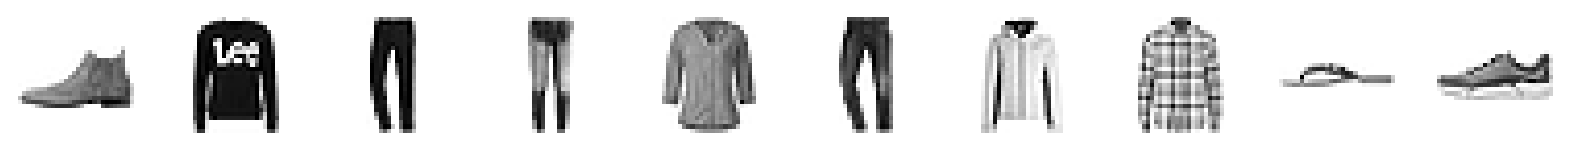

Reconstructions


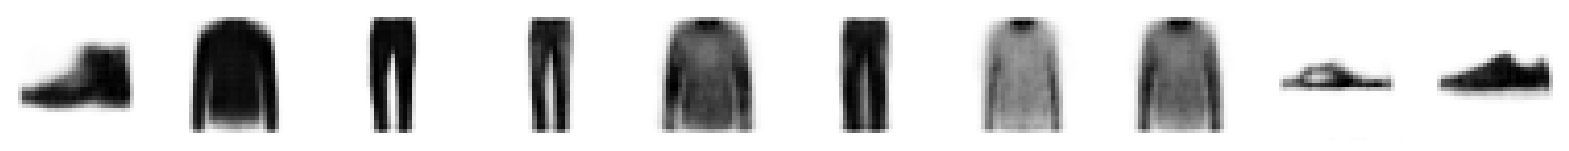

In [30]:
predictions = autoencoder.predict(example_images)

print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(predictions)

Обратите внимание, что реконструкция не идеальна — в исходных изображениях все еще есть некоторые детали, которые не фиксируются в процессе декодирования, например логотипы. Это связано с тем, что, сокращая каждое изображение всего до двух чисел, мы, естественно, теряем некоторую информацию.

### Визуализация латентного пространства <a name="encode"></a>

Можно визуализировать изображения в скрытом (латентном) пространстве, пропуская тестовый набор через кодировщик и отображая полученные точки.

In [31]:
# Encode the example images
embeddings = encoder.predict(example_images)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Эмбеддинг (вложение) — это уменьшение размерности признакового пространства ради повышения производительности модели или других целей. 

In [32]:
# Some examples of the embeddings
print(embeddings[:10])

[[ 1.7178348   1.8295133 ]
 [ 5.880697   -3.8568764 ]
 [-3.0648448  -6.3299756 ]
 [-1.9945716  -3.6896198 ]
 [ 3.499811   -1.6244596 ]
 [-1.3813131  -5.2777705 ]
 [ 1.8320242  -1.7197794 ]
 [ 2.7477362  -1.7764586 ]
 [-0.41122153  2.2871892 ]
 [ 0.7755359   3.4894876 ]]


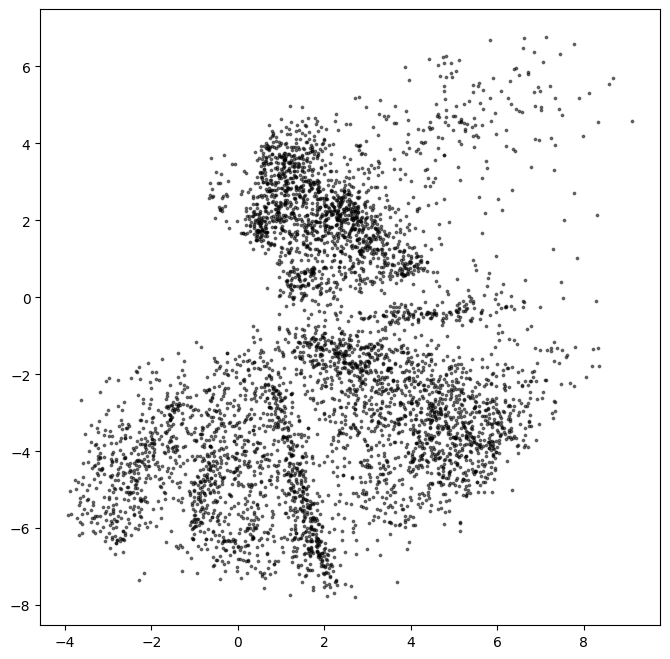

In [33]:
# Show the encoded points in 2D space
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)
plt.show()

Чтобы лучше понять, как структурировано это скрытое пространство, можно использовать метки, поставляемые с набором данных Fashion-MNIST, описывающие тип предмета на каждом изображении. Всего существует 10 групп предметов:

* 0 – T-shirt/top
* 1 – Trouser
* 2 – Pullover
* 3 – Dress
* 4 – Coat
* 5 – Sandal
* 6 – Shirt
* 7 – Sneaker
* 8 – Bag
* 9 – Ankle boot


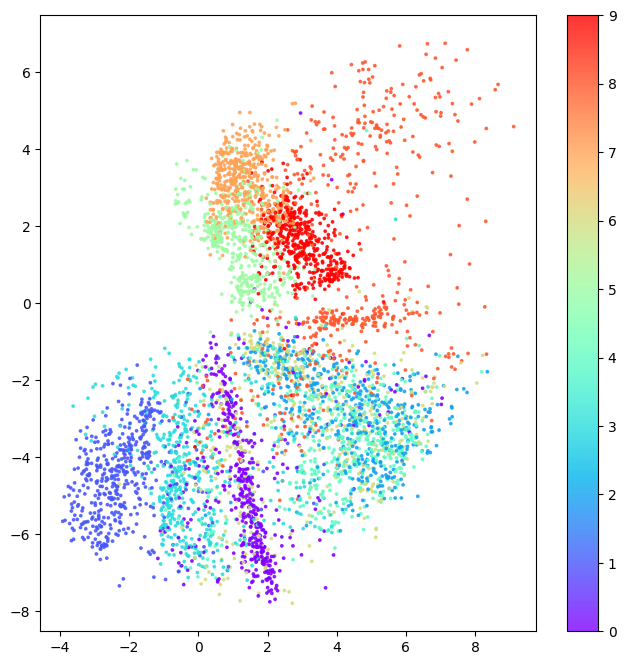

In [34]:
# Colour the embeddings by their label 
example_labels = y_test[:n_to_predict]

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

Несмотря на то, что метки одежды никогда не показывались модели во время обучения, автоэнкодер естественным образом сгруппировал предметы, которые выглядят одинаково, в одних и тех же частях скрытого пространства. Например, темно-синее облако точек в правом нижнем углу скрытого пространства — это разные изображения брюк, а красное облако точек ближе к центру — это обувь.

### Генерация при помощи декодера <a name="decode"></a>

Можно сгенерировать новые изображения, выбирая некоторые точки в скрытом пространстве и используя декодер для преобразования их обратно в пространство пикселей.

In [35]:
# Get the range of the existing embeddings
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

# Sample some points in the latent space
grid_width, grid_height = (6, 3)
sample = np.random.uniform(
    mins, maxs, size=(grid_width * grid_height, EMBEDDING_DIM)
)

In [36]:
# Decode the sampled points
reconstructions = decoder.predict(sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


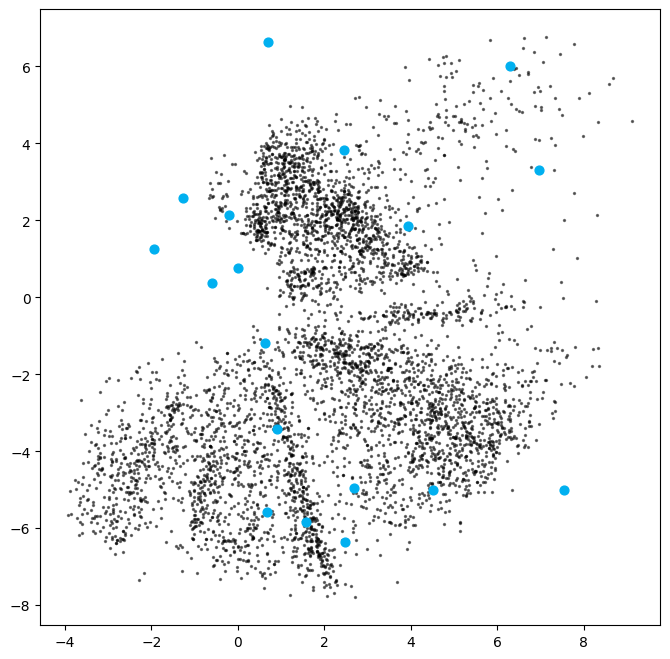

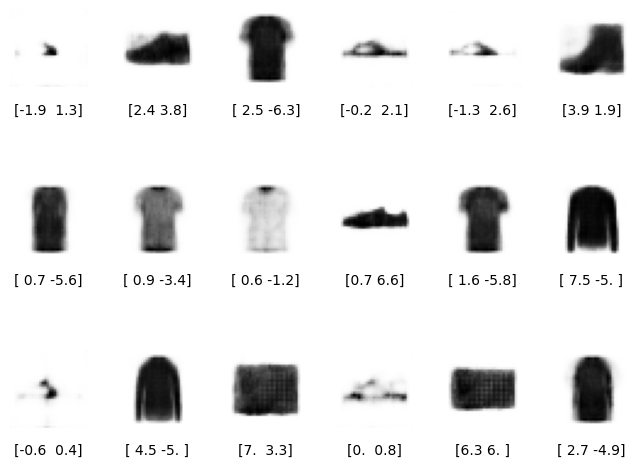

In [37]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

Каждая синяя точка соответствует одному из изображений, показанных ниже диаграммы, с вектором эмбеддинга, показанным под ней. Некоторые из созданных элементов более реалистичны, чем другие. Почему так?

* Некоторые предметы одежды представлены на очень небольшой площади, а другие — на гораздо большей.
* Распределение не симметрично относительно точки (0, 0) или ограничено. Например, существует гораздо больше точек с положительными значениями оси Y, чем с отрицательными, а некоторые точки даже простираются до значения оси Y > 8.
* Между цветами имеются большие промежутки, содержащие мало точек.

Поэтому выборка из скрытого пространства является весьма сложной задачей. Если наложить на скрытое пространство изображения декодированных точек сетки, то можно понять, почему декодер не всегда может генерировать удовлетворительные изображения.

Теперь выполним цветную визуализацию в латентном пространстве.

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


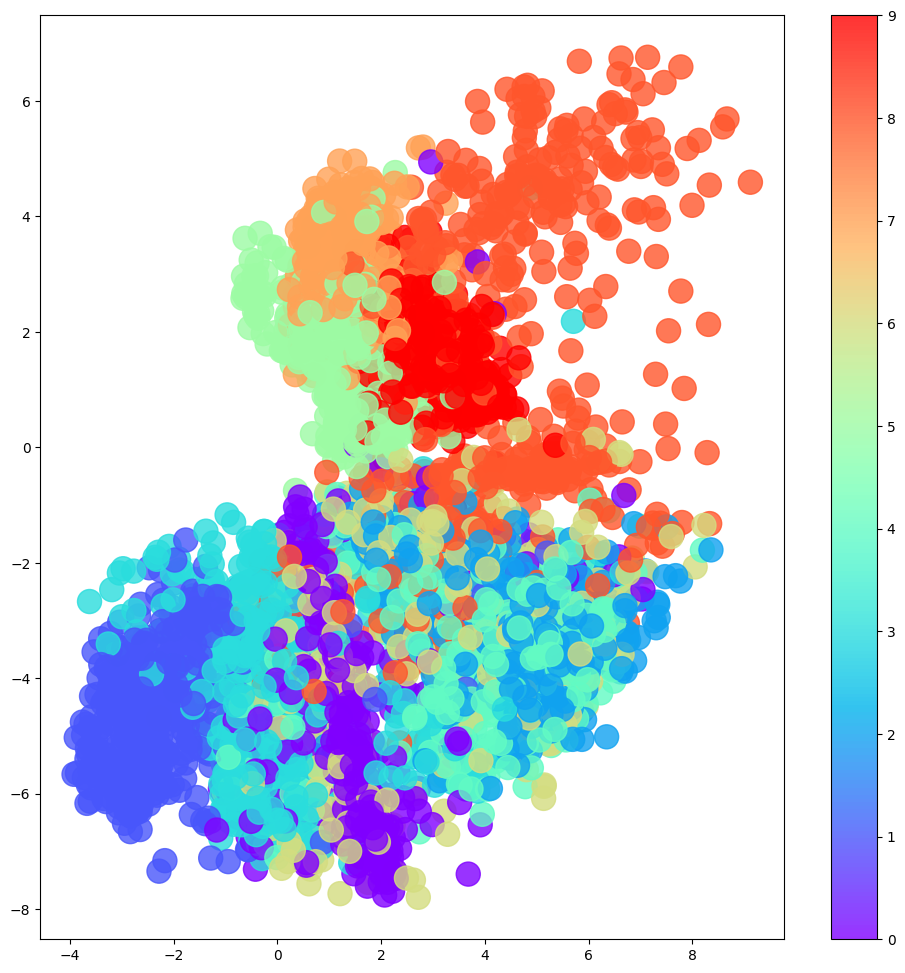

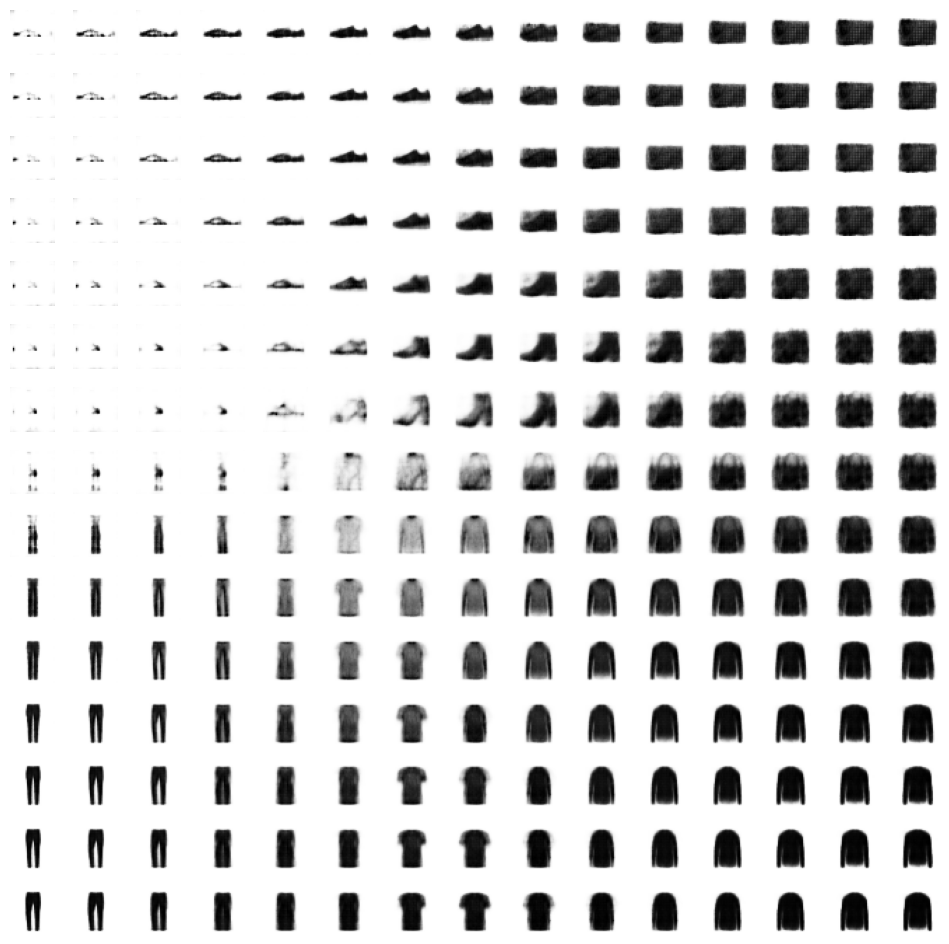

In [38]:
# Colour the embeddings by their label 
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=300,
)
plt.colorbar()

x = np.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), grid_size)
y = np.linspace(max(embeddings[:, 1]), min(embeddings[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

При применении автокодировщика для генерации изображений возникает три проблемы:

* если выбираем точки равномерно в ограниченном пространстве, то мы с большей вероятностью выберем предмет, который занимает большую область пространства

* так как распределение точек в латентном пространстве не определено, неочевидно, как следует выбирать случайную точку в этом пространстве, технически можно бы выбрать любую точку двумерной плоскости

* наконец, в латентном пространстве имеются пустые области, где ни одно из исходных изображений не закодировано. Например, по краям области имеются большие белые пространства — у автокодировщика нет причин гарантировать, что точки здесь декодируются в узнаваемые предметы одежды, поскольку здесь кодируется очень мало изображений в обучающем наборе. В двух измерениях эта проблема не является серьезной – автоэнкодер имеет лишь небольшое количество измерений, с которыми он может работать, поэтому, естественно, ему приходится сжимать группы одежды вместе, в результате чего пространство между группами одежды становится относительно небольшим. Однако по мере того, как мы начинаем использовать больше измерений скрытого пространства для создания более сложных изображений, таких как лица, эта проблема становится еще более очевидной. Если мы дадим автокодировщику полную свободу действий в том, как он использует скрытое пространство для кодирования изображений, между группами схожих точек возникнут огромные промежутки, и наличие этих промежутков будет мешать генерировать правильно сформированные изображения.

### Постановка задачи о генеративной модели

Задан набор данных $\mathbf{X}$, причем предполагается, что данные в $\mathbf{X}$ имеют некоторое неизвестное вероятностное распределением $p_{d}$. 

Требуется построить генеративную модель, порождающую вероятностное распределение $p_{m}$, которое имитирует распределение $p_{d}$. 

Если эта цель будет достигнута, то можно будет делать выборку из распределения $p_{m}$, чтобы генерировать новые данные, которые выглядят как данные из распределения $p_{d}$. 

В качестве генеративной модели мог бы выступать декодер автокодировщика, но для этого требуется решить проблемы, указанные выше. Чтобы решить эти проблемы, нужно от автокодировщика перейти к __вариационному автокодировщику__.

### Вариационные автокодировщики

Вместо того, чтобы напрямую выводить значения скрытого состояния, как в стандартном автокодировщике, кодировщик вариационного автокодировщика (VAE) выводит параметры, **описывающие распределение для каждого измерения в скрытом пространстве**. Поскольку мы предполагаем, что наше априорное распределение соответствует нормальному, мы выводим два вектора, описывающих среднее значение и дисперсию распределения скрытого состояния. Если бы мы хотели построить полноценную многомерную гауссову модель, то нам нужно было бы определить ковариационную матрицу, описывающую, как коррелирует каждое из измерений. Однако мы сделаем упрощающее предположение, что наша ковариационная матрица имеет ненулевые значения только на диагонали, что позволяет нам описать эту информацию в виде простого вектора.

Затем кодировщик генерирует скрытый вектор путем выборки из этого нормального распределения и декодер реконструирует исходный входной сигнал.

Эта организация процесса работы вариационного автокодировщика показана на изображении ниже:

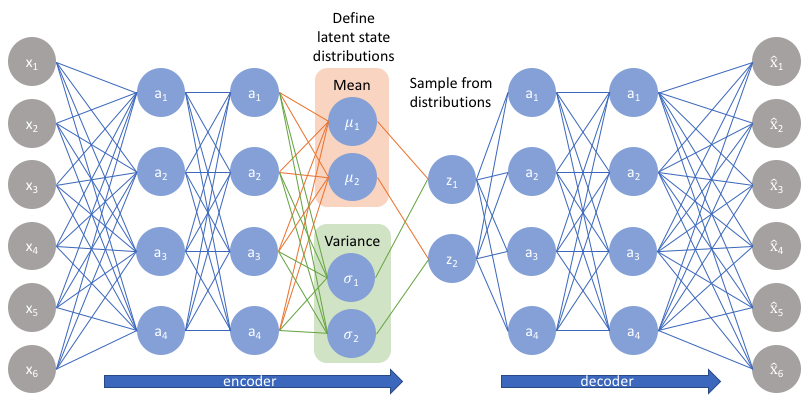

## Статистическое обоснование VAE

Следуя общей логике автокодировщиков (AE), предположим, что существует некоторая скрытая переменная $\mathbf{z}$, которая  создает наблюдение $\mathbf{x}$.


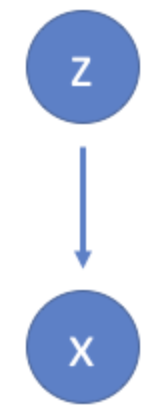

Получив выходное значение $\mathbf{x}$, мы хотели бы вывести характеристики переменной $\mathbf{z}$. Другими словами, мы хотели бы вычислить условное распределение вероятностей $p\left(\mathbf{z}\mid\mathbf{x}\right)$, используя байесовский вывод согласно формуле Байеса:

$$p\left(\mathbf{z}\mid\mathbf{x}\right) = \frac{
p\left(\mathbf{x}\mid\mathbf{z}\right)p\left(\mathbf{z}\right)}{p\left(\mathbf{x}\right)}$$

(в формуле Байеса могут фигурировать как вероятности, так и плотности вероятностей).

Известно, что вычислить $p\left(\mathbf{x}\right)$ довольно сложно. Для непрерывных распределений нужно интегрировать по всем $\mathbf{z}$, как показано ниже:

$$ p\left(\mathbf{x}\right) = 
\int {p\left(\mathbf{x}\mid\mathbf{z}\right)
p\left(\mathbf{z}\right)d\mathbf{z}},$$

то есть мы исключаем $\mathbf{z}$ из распределения вероятностей $p\left(\mathbf{x}\mid\mathbf{z}\right)$.


Используя VAE, можно применить т.н. __вариационный вывод__ для оценки этого значения. Можно аппроксимировать $p\left(\mathbf{z}\mid\mathbf{x}\right)$, рассматривая другое, легко поддающееся обработке (tractable) распределение $q\left(\mathbf{z}\mid\mathbf{x}\right)$. Мы определяем параметры распределения $q\left(\mathbf{z}\mid\mathbf{x}\right)$ так, чтобы оно  было очень похоже на распределение $p\left(\mathbf{z}\mid\mathbf{x}\right)$, тогда мы сможем использовать его для выполнения приблизительного вывода (approximate inference) для трудноразрешимого распределения $p\left(\mathbf{z}\mid\mathbf{x}\right)$.

> __Распределение называется легко поддающимся обработке (tractable), если любую порожденную им предельную (маржинальную) вероятность можно вычислить за линейное время.__

Идея VAE состоит в том, чтобы вывести $p\left(\mathbf{z}\right)$, используя $p\left(\mathbf{z}\mid\mathbf{x}\right)$, т.е. мы хотим сделать нашу скрытую переменную **правдоподобной** для имеющихся данных. В случае MNIST мы хотим ограничиться только допустимыми цифрами.

### Вариационный вывод (Variational Inference) 

Сперва нам нужно вывести апостериорное распределение $p\left(\mathbf{z}\mid\mathbf{x}\right)$, поскольку мы его еще не знаем. В VAE мы выводим $p\left(\mathbf{z}\mid\mathbf{x}\right)$, используя метод под названием **вариационный вывод (VI)**. VI — это один из популярных методов байесовского вывода, другой популярный метод — это метод Марковских цепей Монте-Карло (MCMC).

> Вариационный вывод (VI) сводит задачу байесовского вывода к задаче оптимизации путем моделирования истинного распределения $p\left(\mathbf{z}\mid\mathbf{x}\right)$ при помощи более простого распределения (например, нормального распределения), которое легко оценить, и минимизации разницы между этими двумя распределениями с помощью **KL-дивергенции**, которая показывает, насколько различны распределения $p$ и $q$.


### Дивергенция (расхождение) Кульбака-Лейблера (KL-дивергенция)

__KL-дивергенция__  показывает, насколько хорошо распределение вероятностей $Q$ аппроксимирует распределение вероятностей $P$ путем вычисления перекрестной энтропии $P$ и $Q$ за вычетом энтропии $P$.

$$D_{KL} (P||Q) = H(P,Q) - H(P)$$ 

Для дискретных вероятностных распределений

$${\displaystyle D_{KL}(P\parallel Q)=\sum \limits _{i=1}^{n}p_{i}\log {\frac {p_{i}}{q_{i}}}}$$

Для абсолютно непрерывных вероятностных распределений $P$ и $Q$ дивергенция Кульбака — Лейблера задаётся выражением

$${\displaystyle D_{\mathrm {KL} }(P\parallel Q)=\int _{X}\,p(x)\log {\frac {p(x)}{q(x)}}\,{\rm {d}}x},
$$

где $p(x)$ и $q(x)$ — функции плотности распределений $P$ и $Q$ соответственно, определённые в области  
$X\subseteq R^{k}$.

KL-дивергенция – это неотрицательная и асимметричная мера. KL-дивергенция используется для того, чтобы заставить распределение скрытых переменных быть нормальным, чтобы мы могли выбирать скрытые переменные из нормального распределения. Таким образом, расхождение KL включено в функцию потерь, чтобы улучшить сходство между распределением скрытых переменных и нормальным распределением. Применим это на практике для расчета  функции потерь.


### Приближенное апостериорное распределение

Вариационный автокодировщик (VAE) – это генеративная модель и она оценивает функцию плотности вероятности (PDF) обучающих данных. 

Пусть $p_{\boldsymbol{\theta}}\left(\mathbf{x},\mathbf{z}\right)$ – генеративная модель с наблюдаемыми переменными $\mathbf{x}$ и латентными (скрытыми) переменными $\mathbf{z}$. 

Задачи апостериорного вывода (построения апостериорного распределения $p_{\boldsymbol{\theta}}\left(\mathbf{z}\mid\mathbf{x}\right)$) и обучения для глубоких моделей с латентными (скрытыми) переменными (deep latent variable model, DLVM) являются труднорешаемыми.

Чтобы превратить эти задачи в решаемые, вводится параметрическая модель вывода $q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)$, которая также называется __энкодером__ (кодировщиком). Через $\boldsymbol{\phi}$ обозначаются параметры этой модели вывода, также называемые __вариационными параметрами__. Мы оптимизируем вариационные параметры $\boldsymbol{\phi}$ так, чтобы:

$$q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)\approx p_{\boldsymbol{\theta}}\left(\mathbf{z}\mid\mathbf{x}\right)$$

Такая аппроксимация апостериорного распределения поможет нам оптимизировать предельное правдоподобие $p_{\boldsymbol{\theta}}\left(\mathbf{x}\right)$.

Приближенное апостериорное распределение $q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)$ можно параметризовать с помощью глубоких нейронных сетей. В этом случае вариационные параметры $\boldsymbol{\phi}$ включают в себя веса и смещения нейронной сети. Например, возможно такое построение распределения $q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)$:

$$q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)=\mathcal{N}\left(\mathbf{z};\boldsymbol{\mu},\mathrm{diag}\left(\boldsymbol{\sigma}\right)\right),\,\left(\boldsymbol{\mu},\log\boldsymbol{\sigma}\right)=e_{\boldsymbol{\phi}}\left(\mathbf{x}\right),$$

где $e_{\boldsymbol{\phi}}\left(\mathbf{x}\right)$ – нейронная сеть какой-либо архитектуры.

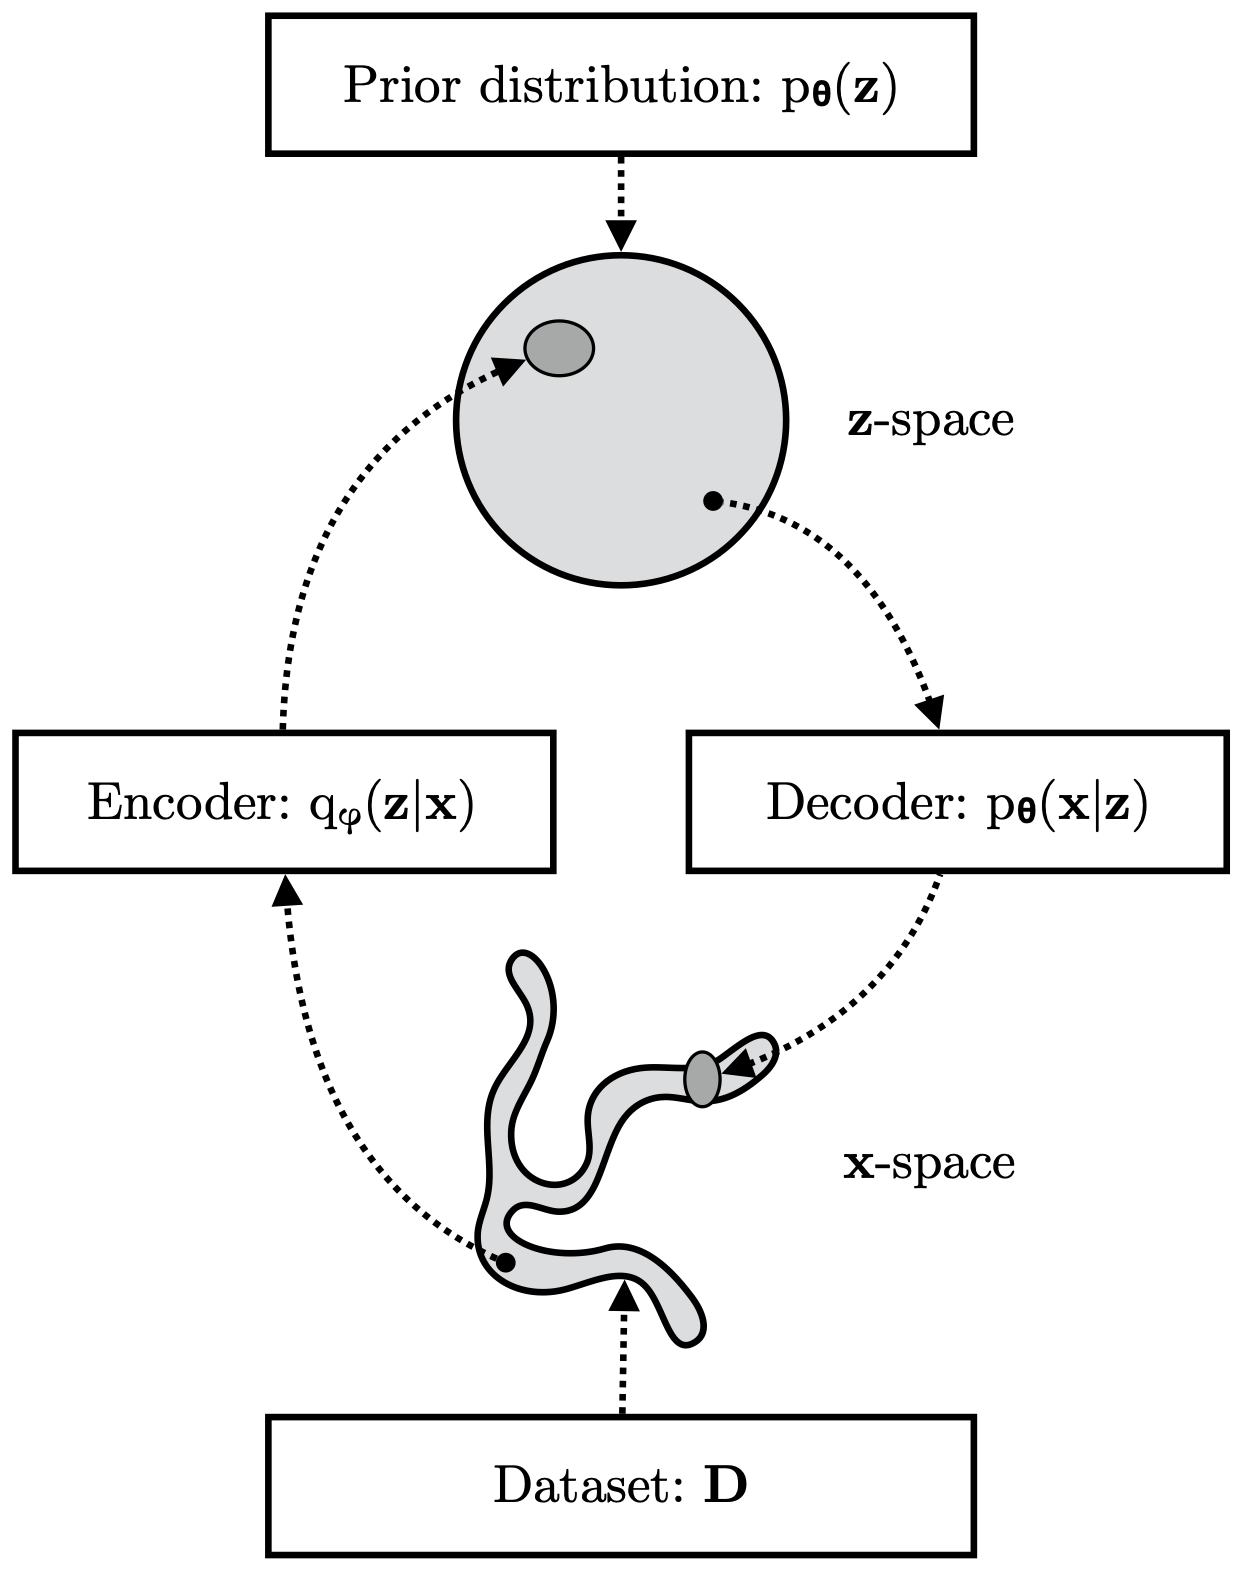

Как правило, для VAE используется одна нейронная сеть – кодировщик для выполнения апостериорного вывода по всем точкам данных в нашем наборе данных. 

### Нижняя граница обоснованности (ELBO)

Целью оптимизации вариационного автоэнкодера, как и в других вариационных методах, является __нижняя граница обоснованности__, сокращенно __ELBO__ (evidence lower bound). Альтернативным термином для этой целевой функции является термин __вариационная нижняя граница__. Как правило, величину ELBO выводят с помощью неравенства Дженсена (Йенсена). Здесь мы воспользуемся альтернативным выводом, который позволяет избежать неравенства Дженсена и лучше понять точность ELBO.

Вариационный энкодер (VAE) изучает стохастические отображения между наблюдаемым $\mathbf{x}$-пространством, эмпирическое распределение которого $q_{\mathcal{D}}\left(\mathbf{x}\right)$ обычно сложное, и латентным (скрытым) $\mathbf{z}$-пространством, распределение которого может быть относительно простым (например, сферическим, как на рисунке выше). Генеративная модель изучает совместное распределение $p_{\boldsymbol{\theta}}\left(\mathbf{x},\mathbf{z}\right)=p_{\boldsymbol{\theta}}\left(\mathbf{z}\right)p_{\boldsymbol{\theta}}\left(\mathbf{x}\mid\mathbf{z}\right)$, разложенное на априорное распределение по латентному (скрытому) пространству $p_{\boldsymbol{\theta}}\left(\mathbf{z}\right)$ и стохастический декодер $p_{\boldsymbol{\theta}}\left(\mathbf{x}\mid\mathbf{z}\right)$. Стохастический кодировщик $q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)$, также называемый моделью вывода, аппроксимирует истинное, но неразрешимое апостериорное распределение $p_{\boldsymbol{\theta}}\left(\mathbf{z}\mid\mathbf{x}\right)$ генеративной модели.

При любом выборе модели вывода $q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)$, включая выбор вариационных параметров $\boldsymbol{\phi}$, имеем:

$$\begin{alignedat}{1}\log p_{\boldsymbol{\theta}}\left(\mathbf{x}\right) & =\mathbb{E}_{q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)}\left[\log p_{\boldsymbol{\theta}}\left(\mathbf{x}\right)\right]=\\
 & =\mathbb{E}_{q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)}\left[\log\left(\frac{p_{\boldsymbol{\theta}}\left(\mathbf{x},\mathbf{z}\right)}{p_{\boldsymbol{\theta}}\left(\mathbf{z}\mid\mathbf{x}\right)}\right)\right]=\\
 & =\mathbb{E}_{q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)}\left[\log\left(\frac{p_{\boldsymbol{\theta}}\left(\mathbf{x},\mathbf{z}\right)}{q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)}\frac{q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)}{p_{\boldsymbol{\theta}}\left(\mathbf{z}\mid\mathbf{x}\right)}\right)\right]=\\
 & =\underbrace{\mathbb{E}_{q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)}\left[\log\left(\frac{p_{\boldsymbol{\theta}}\left(\mathbf{x},\mathbf{z}\right)}{q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)}\right)\right]}_{\mathcal{L}_{\boldsymbol{\theta,\phi}}\left(\mathbf{x}\right)}+\underbrace{\mathbb{E}_{q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)}\left[\log\left(\frac{q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)}{p_{\boldsymbol{\theta}}\left(\mathbf{z}\mid\mathbf{x}\right)}\right)\right]}_{D_{\mathbb{KL}}\left(q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)\parallel p_{\boldsymbol{\theta}}\left(\mathbf{z}\mid\mathbf{x}\right)\right)}
\end{alignedat}$$


Второе слагаемое в уравнении представляет собой __расхождение (дивергенцию) Кульбака-Лейблера (KL-дивергенцию)__ между $q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)$ и $p_{\boldsymbol{\theta}}\left(\mathbf{z}\mid\mathbf{x}\right)$ и является неотрицательным (это вытекает из неравенства Гиббса):

$$D_{\mathbb{KL}}\left(q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)\parallel p_{\boldsymbol{\theta}}\left(\mathbf{z}\mid\mathbf{x}\right)\right)\geqslant0$$

и равно нулю тогда и только тогда, когда аппроксимация $$q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)$$ (почти всюду) равна истинному апостериорному распределению $$p_{\boldsymbol{\theta}}\left(\mathbf{z}\mid\mathbf{x}\right)$$. 

Первое слагаемое в уравнении – это __вариационная нижняя граница__, называемая также __нижней границей обоснованности (ELBO)__:

$$\mathcal{L}_{\boldsymbol{\theta,\phi}}\left(\mathbf{x}\right)=\mathbb{E}_{q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)}\left[\log\left(\frac{p_{\boldsymbol{\theta}}\left(\mathbf{x},\mathbf{z}\right)}{q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)}\right)\right]=\mathbb{E}_{q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)}\left[\log p_{\boldsymbol{\theta}}\left(\mathbf{x},\mathbf{z}\right)-\log q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)\right]$$

Из-за неотрицательности KL-расхождения ELBO является нижней границей логарифмического правдоподобия данных $\log p_{\boldsymbol{\theta}}\left(\mathbf{x}\right)$:

$$\mathcal{L}_{\boldsymbol{\theta,\phi}}\left(\mathbf{x}\right)=\log p_{\boldsymbol{\theta}}\left(\mathbf{x}\right)-D_{\mathbb{KL}}\left(q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)\parallel p_{\boldsymbol{\theta}}\left(\mathbf{z}\mid\mathbf{x}\right)\right)\leqslant\log p_{\boldsymbol{\theta}}\left(\mathbf{x}\right)$$

Итак, KL-дивергенция $D_{\mathbb{KL}}\left(q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)\parallel p_{\boldsymbol{\theta}}\left(\mathbf{z}\mid\mathbf{x}\right)\right)$ определяет два расстояния:

1. Расхождение (KL-дивергенция) приближенного апостериорного распределения $q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)$ от истинного апостериорного распределения $p_{\boldsymbol{\theta}}\left(\mathbf{z}\mid\mathbf{x}\right)$.

2. Разрыв между ELBO $\mathcal{L}_{\boldsymbol{\theta,\phi}}\left(\mathbf{x}\right)$ и предельным логарифмическим правдоподобием $\log p_{\boldsymbol{\theta}}\left(\mathbf{x}\right)$. Чем лучше $q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)$ аппроксимирует истинное (апостериорное) распределение $p_{\boldsymbol{\theta}}\left(\mathbf{z}\mid\mathbf{x}\right)$ с точки зрения KL-дивергенции, тем меньше этот разрыв.

Простая схема вычислительного потока в вариационном автоэнкодере показана на рисунке.

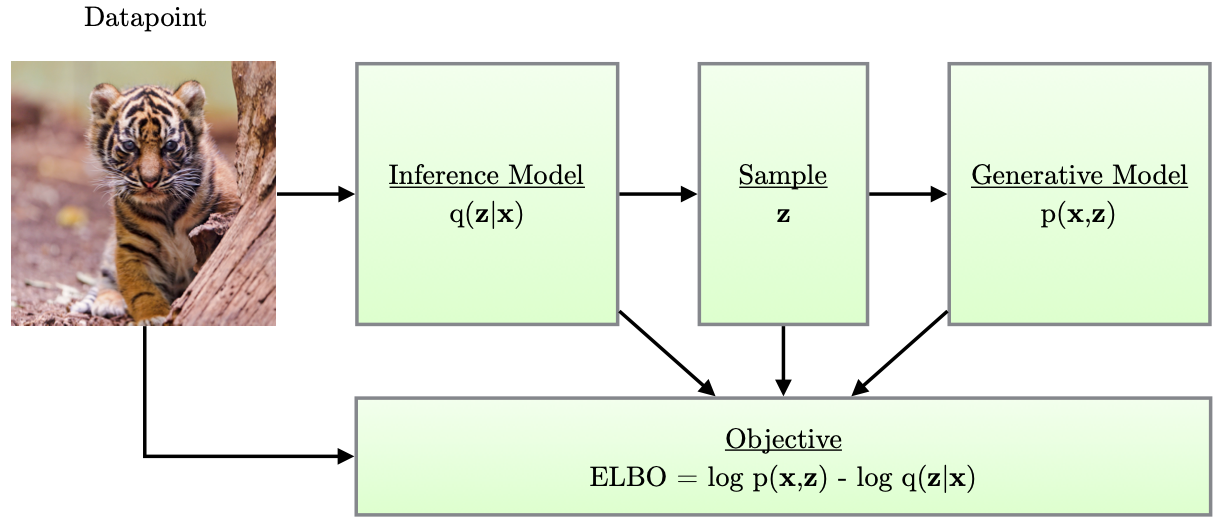

Глядя на неравенство для ELBO, можно понять, что максимизация ELBO $\mathcal{L}_{\boldsymbol{\theta,\phi}}\left(\mathbf{x}\right)$ относительно параметров $\boldsymbol{\theta}$ и $\boldsymbol{\phi}$ одновременно оптимизирует две важные для нас величины:

1. Это приблизительно максимизирует предельное правдоподобие $p_{\boldsymbol{\theta}}\left(\mathbf{x}\right)$. Это означает, что наша генеративная модель работает лучше. 

2. Это минимизирует KL-расхождение аппроксимации $q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)$ от истинного апостериорного распределения $p_{\boldsymbol{\theta}}\left(\mathbf{z}\mid\mathbf{x}\right)$, так что приближенное распределение $q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)$ становится лучше.

### Стохастическая градиентная оптимизация ELBO

Важным свойством ELBO является то, что он позволяет проводить совместную оптимизацию по всем параметрам ($\boldsymbol{\theta}$ и $\boldsymbol{\phi}$) с использованием стохастического градиентного спуска (SGD). Мы можем начать со случайных начальных значений $\boldsymbol{\theta}$ и $\boldsymbol{\phi}$ и стохастически оптимизировать их значения до сходимости. 

Пусть дан набор i.i.d. (independent identically distributed) независимых и одинаково распределенных данных $\mathcal{D}$, тогда целевая функция для ELBO представляет собой сумму (или среднее значение) ELBO для отдельных точек данных:

$$\mathcal{L}_{\boldsymbol{\theta,\phi}}\left(\mathcal{D}\right)=\sum_{\mathbf{x}\in\mathcal{D}}\mathcal{L}_{\boldsymbol{\theta,\phi}}\left(\mathbf{x}\right)$$

Величина ELBO в индивидуальной точке данных $\mathcal{L}_{\boldsymbol{\theta,\phi}}\left(\mathbf{x}\right)$ и ее градиент $\nabla_{\boldsymbol{\theta,\phi}}\mathcal{L}_{\boldsymbol{\theta,\phi}}\left(\mathbf{x}\right)$ в общем случае не разрешимы в замкнутом виде. Однако хорошие несмещенные оценки $\nabla_{\boldsymbol{\theta,\phi}}\mathcal{L}_{\boldsymbol{\theta,\phi}}\left(\mathbf{x}\right)$ существуют, так что можно применять минипакетный SGD. 

Несмещенные градиенты ELBO относительно параметров генеративной модели $\boldsymbol{\theta}$ получить просто:

$$\begin{alignedat}{1}\nabla_{\boldsymbol{\theta}}\mathcal{L}_{\boldsymbol{\theta,\phi}}\left(\mathbf{x}\right) & =\nabla_{\boldsymbol{\theta}}\mathbb{E}_{q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)}\left[\log p_{\boldsymbol{\theta}}\left(\mathbf{x},\mathbf{z}\right)-\log q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)\right]=\\
 & =\mathbb{E}_{q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)}\left[\nabla_{\boldsymbol{\theta}}\left\{ \log p_{\boldsymbol{\theta}}\left(\mathbf{x},\mathbf{z}\right)-\log q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)\right\} \right]=\\
 & =\mathbb{E}_{q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)}\left[\nabla_{\boldsymbol{\theta}}\left\{ \log p_{\boldsymbol{\theta}}\left(\mathbf{x},\mathbf{z}\right)\right\} \right]\approx\\
 & \approx\nabla_{\boldsymbol{\theta}}\log p_{\boldsymbol{\theta}}\left(\mathbf{x},\mathbf{z}^{s}\right)
\end{alignedat}$$


Последняя строка представляет собой простую оценку методом Монте-Карло предыдущей строки, где $\mathbf{z}^{s}$ в последней строке представляет собой случайную выборку из $q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)$: $\mathbf{z}^{s}\sim q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)$.

Несмещенные градиенты ELBO относительно вариационных параметров $\boldsymbol{\phi}$ получить труднее, так как математическое ожидание ELBO берется относительно распределения $q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)$, которое является функцией $\boldsymbol{\phi}.$ Вообще говоря, нельзя поменять местами операцию математического ожидания и градиента:

$$\nabla_{\boldsymbol{\phi}}\mathcal{L}_{\boldsymbol{\theta,\phi}}\left(\mathbf{x}\right)=\nabla_{\boldsymbol{\phi}}\mathbb{E}_{q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)}\left[\log p_{\boldsymbol{\theta}}\left(\mathbf{x},\mathbf{z}\right)-\log q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)\right]\neq$$
$$\neq\mathbb{E}_{q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)}\left[\nabla_{\boldsymbol{\phi}}\left\{ \log p_{\boldsymbol{\theta}}\left(\mathbf{x},\mathbf{z}\right)-\log q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)\right\} \right]$$

В случае непрерывных скрытых переменных мы можем использовать прием перепараметризации для вычисления несмещенной оценки $\nabla_{\boldsymbol{\theta,\phi}}\mathcal{L}_{\boldsymbol{\theta,\phi}}\left(\mathbf{x}\right)$, как показано ниже. Эта стохастическая оценка позволяет нам оптимизировать ELBO с помощью SGD.

### Прием перепараметризации

Для непрерывных скрытых переменных и дифференцируемого кодировщика и генеративной модели величину ELBO можно прямо дифференцировать по обоим параметрам $\boldsymbol{\theta}$ и $\boldsymbol{\phi}$ при помощи замены переменных, также называемой __приемом перепараметризации__ (__reparameterization trick__).

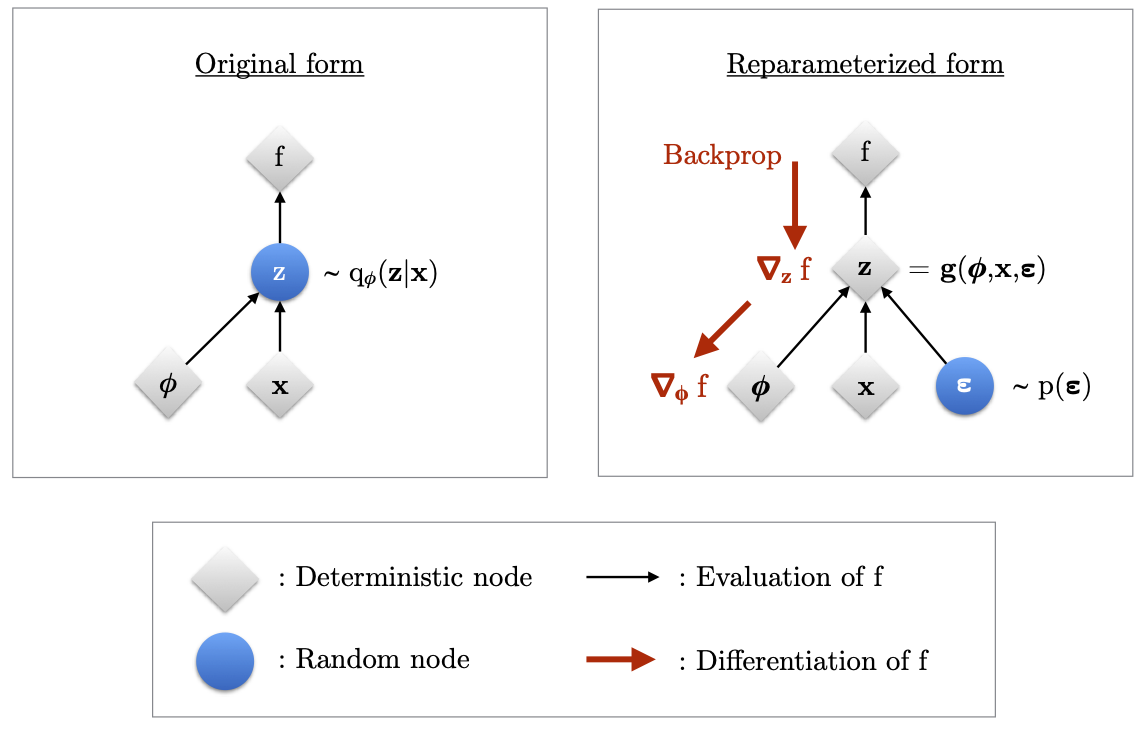

Идея приема перепараметризации состоит в следующем. Вариационные параметры $\boldsymbol{\phi}$ влияют на целевую функцию $f$ через случайную величину $\mathbf{z}\sim q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)$. Необходимо вычислить градиенты $\nabla_{\boldsymbol{\phi}}f$ для оптимизации целевой функции с помощью SGD. В исходной форме (слева) мы не можем дифференцировать $f$ по $\boldsymbol{\phi}$, потому что мы не можем напрямую распространять обратно градиенты через случайную переменную $\mathbf{z}$. Мы можем вынести случайность за пределы $\mathbf{z}$, перепараметризовав переменную $\mathbf{z}$ как детерминированную и дифференцируемую функцию от $\boldsymbol{\phi}$, $\mathbf{x}$ и вновь введенной случайной величины $\boldsymbol{\epsilon}$. Это позволяет нам обеспечить обратное распространение ошибки через $\boldsymbol{z}$ и вычислять градиенты $\nabla_{\boldsymbol{\phi}}f$.

#### Замена переменных

Во-первых, представим случайную величину $\mathbf{z}\sim q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)$ как некоторое дифференцируемое (и обратимое) преобразование другой случайной величины $\boldsymbol{\epsilon}$ при заданных $\mathbf{z}$ и $\boldsymbol{\phi}$:

$$\mathbf{z}=g\left(\boldsymbol{\epsilon},\boldsymbol{\phi},\mathbf{x}\right),$$

где распределение случайной величины $\boldsymbol{\epsilon}$ не зависит от $\mathbf{x}$ или $\boldsymbol{\phi}$.

#### Градиент математического ожидания при замене переменной

При такой замене переменной математическое ожидание можно переписать через $\boldsymbol{\epsilon}$:

$$\mathbb{E}_{q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)}\left[f\left(\mathbf{z}\right)\right]=\mathbb{E}_{p\left(\boldsymbol{\epsilon}\right)}\left[f\left(\mathbf{z}\right)\right],$$

где $\mathbf{z}=g\left(\boldsymbol{\epsilon},\boldsymbol{\phi},\mathbf{x}\right)$, и операторы математического ожидания и градиента становятся коммутативными, и мы можем использовать простую оценку Монте-Карло:

$$\nabla_{\boldsymbol{\phi}}\mathbb{E}_{q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)}\left[f\left(\mathbf{z}\right)\right]=\nabla_{\boldsymbol{\phi}}\mathbb{E}_{p\left(\boldsymbol{\epsilon}\right)}\left[f\left(\mathbf{z}\right)\right]=$$
$$=\mathbb{E}_{p\left(\boldsymbol{\epsilon}\right)}\left[\nabla_{\boldsymbol{\phi}}f\left(\mathbf{z}\right)\right]\approx\nabla_{\boldsymbol{\phi}}f\left(\mathbf{z}^{s}\right),$$

где в последней строке $\mathbf{z}^{s}=g\left(\boldsymbol{\epsilon}^{s},\boldsymbol{\phi},\mathbf{x}\right)$ со случайной выборкой шума $\boldsymbol{\epsilon}^{s}\sim p\left(\boldsymbol{\epsilon}\right)$. 

#### Градиент ELBO

При репараметризации мы можем заменить математическое ожидание относительно $q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)$ математическим ожиданием относительно $p\left(\boldsymbol{\epsilon}\right)$. Величина ELBO можно представлена как:

$$\mathcal{L}_{\boldsymbol{\theta,\phi}}\left(\mathbf{x}\right)=\mathbb{E}_{q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)}\left[\log p_{\boldsymbol{\theta}}\left(\mathbf{x},\mathbf{z}\right)-\log q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)\right]=$$
$$=\mathbb{E}_{p\left(\boldsymbol{\epsilon}\right)}\left[\log p_{\boldsymbol{\theta}}\left(\mathbf{x},\mathbf{z}\right)-\log q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)\right],$$

где $\mathbf{z}=g\left(\boldsymbol{\epsilon},\boldsymbol{\phi},\mathbf{x}\right)$. 

В результате можно получить простую оценку методом Монте-Карло $\tilde{\mathcal{L}}_{\boldsymbol{\theta,\phi}}\left(\mathbf{x}\right)$ для величины ELBO отдельной точки данных $\mathbf{x}$, где используется выборка шума из одной точки $\boldsymbol{\epsilon}^{s}$ из распределения $p\left(\boldsymbol{\epsilon}\right)$:

$$\boldsymbol{\epsilon}^{s}\sim p\left(\boldsymbol{\epsilon}\right)$$
$$\mathbf{z}^{s}=g\left(\boldsymbol{\epsilon}^{s},\boldsymbol{\phi},\mathbf{x}\right)$$
$$\tilde{\mathcal{L}}_{\boldsymbol{\theta,\phi}}\left(\mathbf{x}\right)=\log p_{\boldsymbol{\theta}}\left(\mathbf{x},\mathbf{z}^{s}\right)-\log q_{\boldsymbol{\phi}}\left(\mathbf{z}^{s}\mid\mathbf{x}\right)$$

Эта последовательность операций может быть выражена в виде символьного графа в таких программах, как Tensorflow, и легко продифференцирована по параметрам $\boldsymbol{\theta}$ и $\boldsymbol{\phi}$. Полученный градиент $\nabla_{\boldsymbol{\phi}}\mathcal{L}_{\boldsymbol{\theta,\phi}}\left(\mathbf{x}\right)$ используется для оптимизации ELBO с использованием минипакетного SGD (см. алгоритм 1). Первоначально этот алгоритм назывался алгоритмом Auto-Encoding Variational Bayes (AEVB) (Kingma and Welling, 2013). 

Алгоритм стохастической оптимизации ELBO приводится ниже:

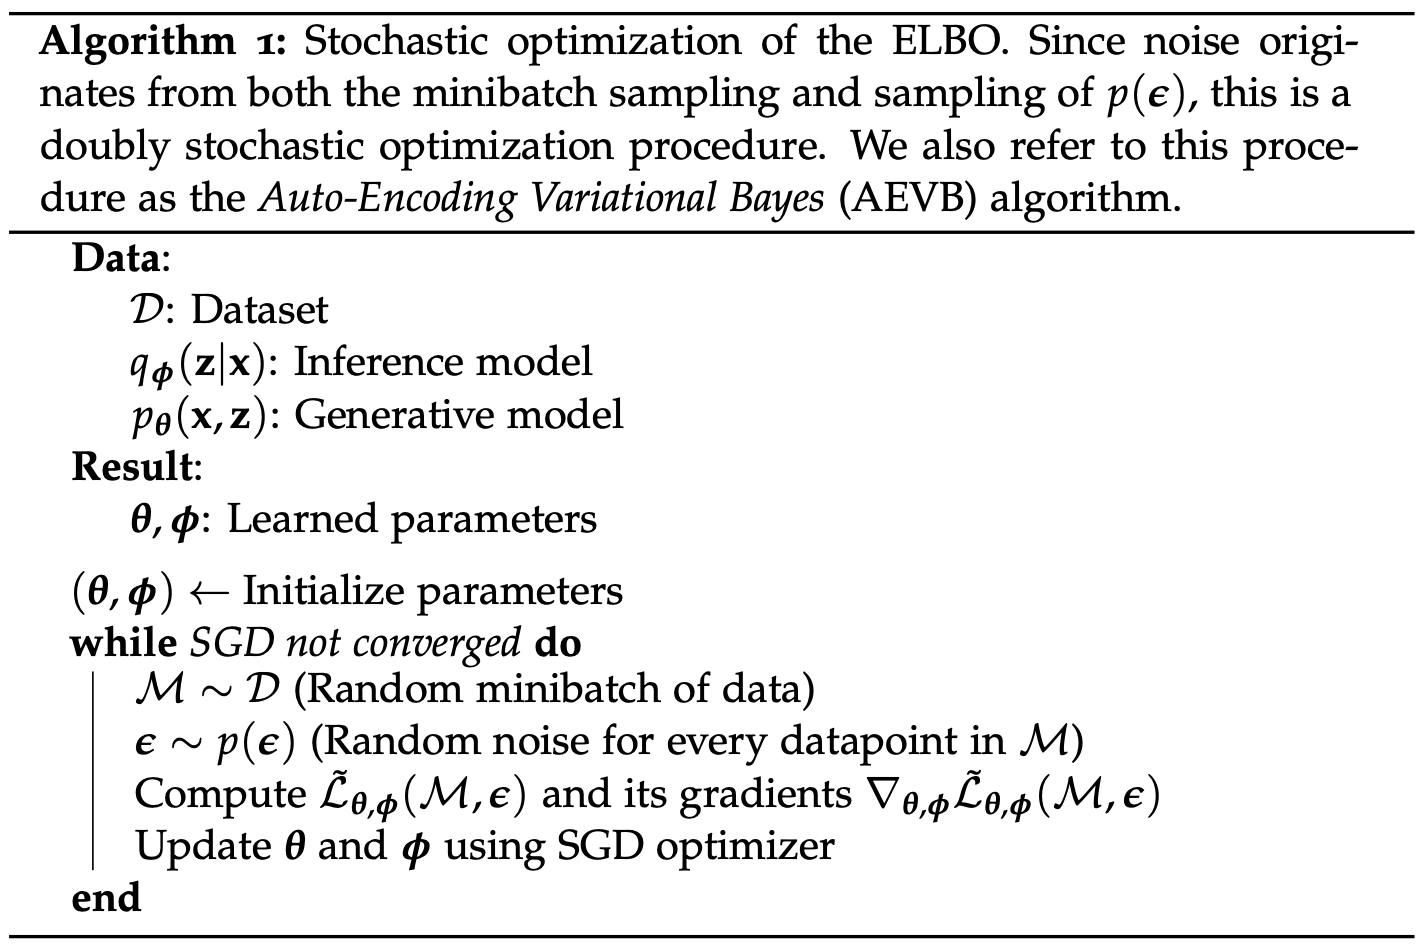

#### Несмещенность

Этот градиент является несмещенной оценкой точного градиента ELBO для одной точки данных; при усреднении по шуму $\boldsymbol{\epsilon}\sim p\left(\boldsymbol{\epsilon}\right)$ этот градиент равен градиенту ELBO для одной точки данных:

$$\mathbb{E}_{p\left(\boldsymbol{\epsilon}\right)}\left[\nabla_{\boldsymbol{\theta,\phi}}\mathcal{\tilde{L}}_{\boldsymbol{\theta,\phi}}\left(\mathbf{x};\boldsymbol{\epsilon}\right)\right]=\mathbb{E}_{p\left(\boldsymbol{\epsilon}\right)}\left[\nabla_{\boldsymbol{\theta,\phi}}\left(\log p_{\boldsymbol{\theta}}\left(\mathbf{x},\mathbf{z}\right)-\log q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)\right)\right]=$$
$$=\nabla_{\boldsymbol{\theta,\phi}}\left(\mathbb{E}_{p\left(\boldsymbol{\epsilon}\right)}\left[\log p_{\boldsymbol{\theta}}\left(\mathbf{x},\mathbf{z}\right)-\log q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)\right]\right)=\nabla_{\boldsymbol{\theta,\phi}}\mathcal{L}_{\boldsymbol{\theta,\phi}}\left(\mathbf{x}\right)$$

#### Вычисление $\log q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)$

Вычисление (оценка) ELBO требует вычисления логарифма плотности $\log q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)$ при заданном значении $\mathbf{x}$ и заданном значении $\mathbf{z}$ или, что эквивалентно, $\boldsymbol{\epsilon}$. Эта логарифмическая плотность представляет собой простое вычисление, если мы выбираем правильное преобразование $g()$. 

Обратите внимание, что обычно мы знаем плотность $p\left(\boldsymbol{\epsilon}\right)$, так как это плотность выбранного распределения шума. Если $g()$ является обратимой функцией, то плотности $\boldsymbol{\epsilon}$ и $\mathbf{z}$ связаны следующим образом:

$$\log q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)=\log p\left(\boldsymbol{\epsilon}\right)-\log d_{\boldsymbol{\phi}}\left(\mathbf{x},\boldsymbol{\epsilon}\right),$$

где второй член представляет собой логарифм абсолютного значения определителя матрицы Якоби $\left(\partial\mathbf{z}/\partial\boldsymbol{\epsilon}\right)$:

$$\log d_{\boldsymbol{\phi}}\left(\mathbf{x},\boldsymbol{\epsilon}\right)=\log\left|\det\left(\frac{\partial\mathbf{z}}{\partial\boldsymbol{\epsilon}}\right)\right|$$

Мы называем это логарифмом определителя преобразования от $\boldsymbol{\epsilon}$ к $\mathbf{z}$. Мы используем обозначение $\log d_{\boldsymbol{\phi}}\left(\mathbf{x},\boldsymbol{\epsilon}\right)$, чтобы показать, что этот логарифм определителя, подобно $g()$, является функцией $\mathbf{x}$, $\boldsymbol{\epsilon}$ и $\boldsymbol{\phi}$. Матрица Якоби содержит все первые производные преобразования от $\boldsymbol{\epsilon}$ к $\mathbf{z}$:

$$\frac{\partial\mathbf{z}}{\partial\boldsymbol{\epsilon}}=\frac{\partial\left(z_{1},z_{2},...,z_{k}\right)}{\partial\left(\epsilon_{1},\epsilon_{2},...,\epsilon_{k}\right)}=\left(\begin{array}{ccc}
\frac{\partial z_{1}}{\partial\epsilon_{1}} & \ldots & \frac{\partial z_{1}}{\partial\epsilon_{k}}\\
\vdots & \ddots & \vdots\\
\frac{\partial z_{k}}{\partial\epsilon_{1}} & \ldots & \frac{\partial z_{k}}{\partial\epsilon_{k}}
\end{array}\right)$$

Как мы покажем, мы можем создавать очень гибкие преобразования $g()$, для которых $\log d_{\boldsymbol{\phi}}\left(\mathbf{x},\boldsymbol{\epsilon}\right)$ легко вычислить, что приводит к очень гибким моделям вывода $q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)$.

#### Факторизованные гауссовские апостериорные распределения

Обычный выбор преобразования – это простой факторизованный гауссовый кодировщик $q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)=\mathcal{N}\left(\mathbf{z};\boldsymbol{\mu},\mathrm{diag}\left(\boldsymbol{\sigma}^{2}\right)\right)$:

$$\left(\boldsymbol{\mu},\log\boldsymbol{\sigma}\right)=e_{\boldsymbol{\phi}}\left(\mathbf{x}\right),$$
$$q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)=\prod_{i}q_{\boldsymbol{\phi}}\left(z_{i}\mid\mathbf{x}\right)=\prod_{i}\mathcal{N}\left(z_{i};\mu_{i},\sigma_{i}^{2}\right),$$

где $\mathcal{N}\left(z_{i};\mu_{i},\sigma_{i}^{2}\right)$ – PDF одномерного гауссового распределения. После репараметризации можно написать:

$$\boldsymbol{\epsilon}\sim\mathcal{N}\left(\mathbf{0},\mathbf{I}\right),$$
$$\left(\boldsymbol{\mu},\log\boldsymbol{\sigma}\right)=e_{\boldsymbol{\phi}}\left(\mathbf{x}\right),$$
$$\mathbf{z}=\boldsymbol{\mu}+\boldsymbol{\sigma}\odot\boldsymbol{\epsilon},$$

где $\odot$ – поэлементное произведение. Якобиан преобразования от $\boldsymbol{\epsilon}$ к $\mathbf{z}$ равен 

$$\frac{\partial\mathbf{z}}{\partial\boldsymbol{\epsilon}}=\mathrm{diag}\left(\boldsymbol{\sigma}\right),$$

т.е. диагональной матрице с элементами $\sigma_{i}$ на диагонали. Определитель диагональной (или, в более общем случае, треугольной) матрицы является произведением ее диагональных элементов. Таким образом, логарифм определителя якобиана равен:

$$\log d_{\boldsymbol{\phi}}\left(\mathbf{x},\boldsymbol{\epsilon}\right)=\log\left|\det\left(\frac{\partial\mathbf{z}}{\partial\boldsymbol{\epsilon}}\right)\right|=\sum_{i}\log\sigma_{i}$$

и апостериорная плотность равна

$$\log q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)=\log p\left(\boldsymbol{\epsilon}\right)-\log d_{\boldsymbol{\phi}}\left(\mathbf{x},\boldsymbol{\epsilon}\right)=\sum_{i}\left(\log\mathcal{N}\left(\epsilon_{i};0,1\right)-\log\sigma_{i}\right),$$

где $\mathbf{z}=g\left(\boldsymbol{\epsilon},\boldsymbol{\phi},\mathbf{x}\right) (=\boldsymbol{\mu}+\boldsymbol{\sigma}\odot\boldsymbol{\epsilon})$. 

#### Гауссовское апостериорное распределение с полной ковариацией

Факторизованное гауссовское апостериорное распределение может быть расширено до гауссовского распределения с полной ковариацией:

$$q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)=\mathcal{N}\left(\mathbf{z};\boldsymbol{\mu},\boldsymbol{\Sigma}\right)$$

Репараметризация этого распределения определяется следующим образом:

$$\boldsymbol{\epsilon}\sim\mathcal{N}\left(\mathbf{0},\mathbf{I}\right),\mathbf{z}=\boldsymbol{\mu}+\mathbf{L}\,\boldsymbol{\epsilon},$$

где $\mathbf{L}$ – нижняя (или верхняя) треугольная матрица с ненулевыми элементами на диагонали. Внедиагональные элементы определяют корреляции (ковариации) элементов в $\mathbf{z}$. 

Причина такой параметризации гауссовского распределения с полной ковариацией заключается в том, что определитель якобиевой матрицы удивительно прост. Якобиева матрица в этом случай тривиальна: $\frac{\partial\mathbf{z}}{\partial\boldsymbol{\epsilon}}=\mathbf{L}$. Заметим, что определитель треугольной матрицы равен произведению ее диагональных элементов. Следовательно, в этой параметризации:

$$\log\left|\det\left(\frac{\partial\mathbf{z}}{\partial\boldsymbol{\epsilon}}\right)\right|=\sum_{i}\log\left|L_{ii}\right|$$

И логарифмическая плотность апостериорного распределения равна:

$$\log q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)=\log p\left(\boldsymbol{\epsilon}\right)-\sum_{i}\log\left|L_{ii}\right|$$

Эта параметризация соответствует разложению Холецкого $\boldsymbol{\Sigma}=\mathbf{L}\,\mathbf{L}^{T}$ ковариации $\mathbf{z}$:

$$\boldsymbol{\Sigma}=\mathbb{E}\left[\left(\mathbf{z}-\mathbb{E}\left[\mathbf{z}\right]\right)\left(\mathbf{z}-\mathbb{E}\left[\mathbf{z}\right]\right)^{T}\right]=$$
$$=\mathbb{E}\left[\mathbf{L}\boldsymbol{\epsilon}\left(\mathbf{L}\boldsymbol{\epsilon}\right)^{T}\right]=\mathbf{L}\mathbb{E}\left[\boldsymbol{\epsilon}\boldsymbol{\epsilon}^{T}\right]\mathbf{L}^{T}=\mathbf{L}\,\mathbf{L}^{T}$$

Обратите внимание, что $\mathbb{E}\left[\boldsymbol{\epsilon}\boldsymbol{\epsilon}^{T}\right]=\mathbf{I}$, так как $\boldsymbol{\epsilon}\sim\mathcal{N}\left(\mathbf{0},\mathbf{I}\right)$.

Один из способов построить матрицу $\mathbf{L}$ с желаемыми свойствами, а именно, треугольностью и ненулевыми диагональными элементами, состоит в следующем:

$$\left(\boldsymbol{\mu},\log\boldsymbol{\sigma},\mathbf{L}^{\prime}\right)=e_{\boldsymbol{\phi}}\left(\mathbf{x}\right),$$
$$\mathbf{L}=\mathbf{L}_{mask}\odot\mathbf{L}^{\prime}+\mathrm{diag}\left(\boldsymbol{\sigma}\right)$$

Здесь $\mathbf{L}_{mask}$ – это маскирующая матрица с нулями на диагонали и выше нее и единицами под диагональю. Логарифм детерминанта матрицы идентичен факторизованному гауссовскому случаю:

$$\log\left|\det\left(\frac{\partial\mathbf{z}}{\partial\boldsymbol{\epsilon}}\right)\right|=\sum_{i}\log\sigma_{i}$$

В более общем случае мы можем заменить $\mathbf{z}=\boldsymbol{\mu}+\mathbf{L}\,\boldsymbol{\epsilon}$ цепочкой (дифференцируемых и нелинейных) преобразований; пока якобиан каждого шага в цепочке треугольный с ненулевыми диагональными элементами, логарифм определителя остается простым. Этот принцип используется обратным авторегрессионным потоком (inverse autoregressive flow, IAF), исследованным Kingma et al. [2016].

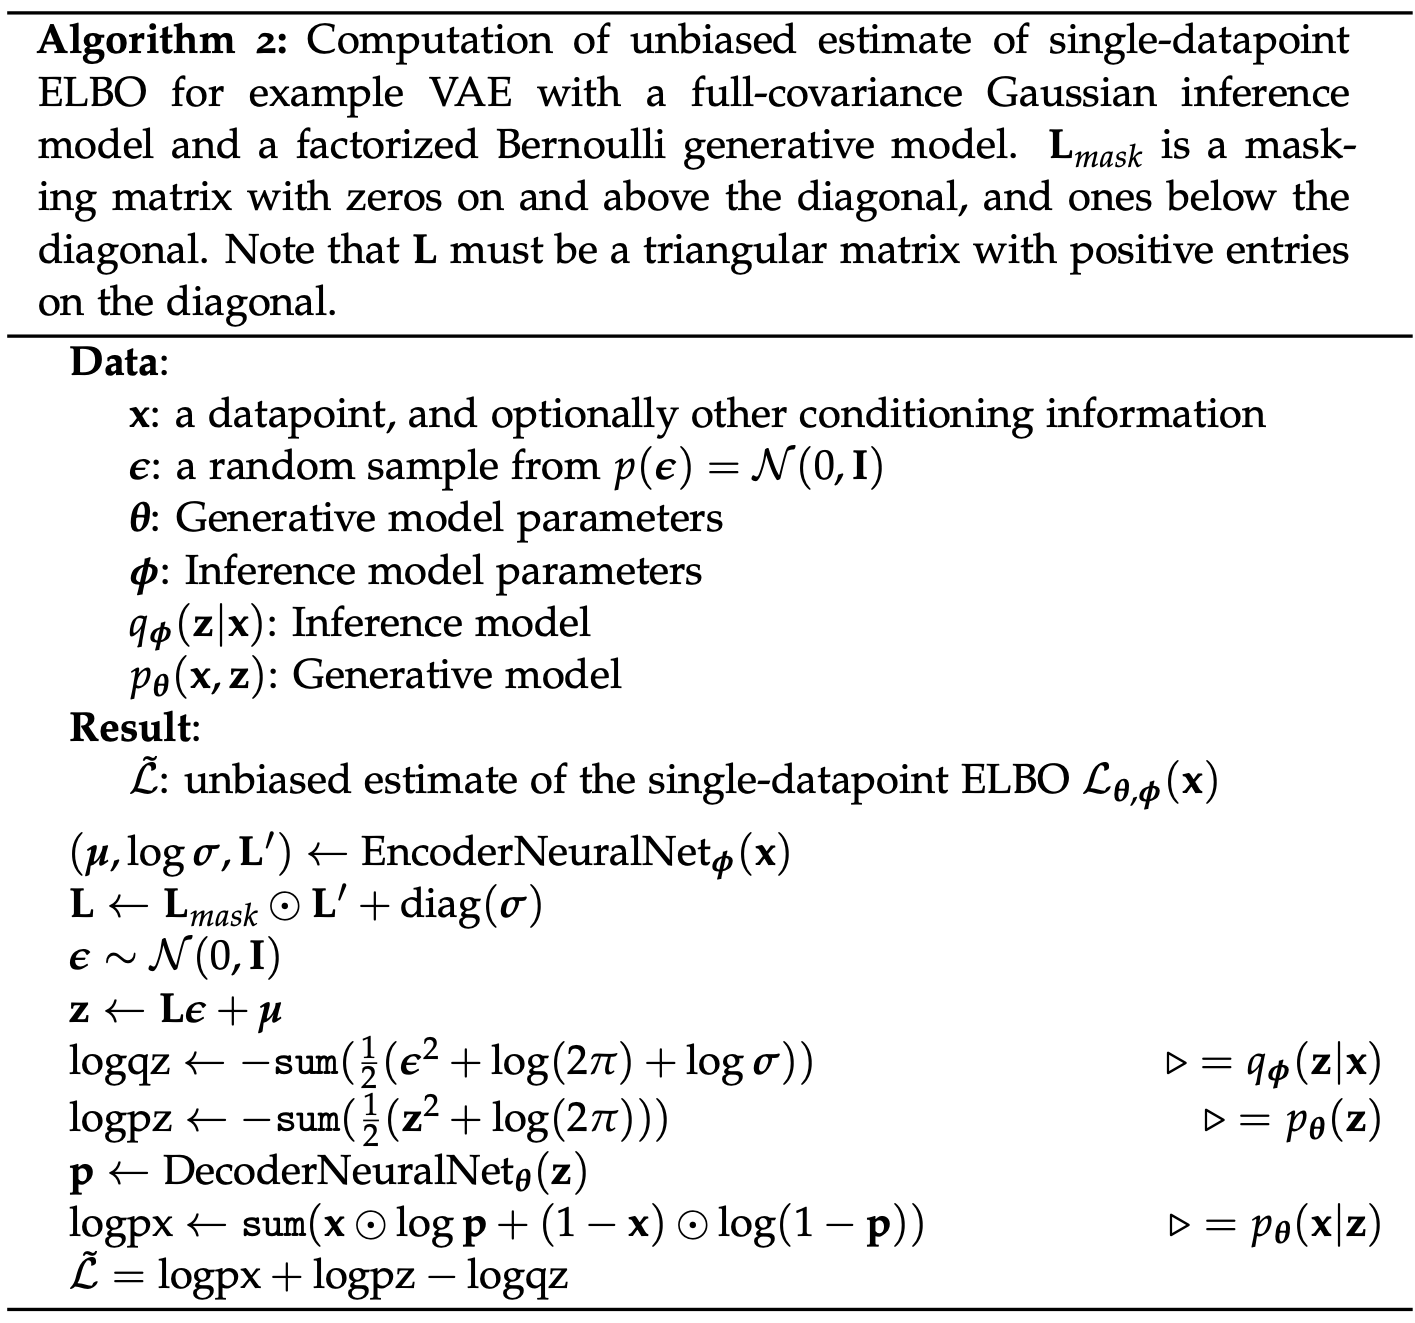

#### Оценка предельного правдоподобия

После обучения VAE мы можем оценить вероятность данных в рамках модели, используя метод выборки по важности (importance sampling). Предельное правдоподобие точки данных может быть записано как:

$$\log p_{\boldsymbol{\theta}}\left(\mathbf{x}\right)=\log\mathbb{E}_{q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)}\left[\frac{p_{\boldsymbol{\theta}}\left(\mathbf{x},\mathbf{z}\right)}{q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)}\right]$$

Случайная выборка из $q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)$ дает следующую оценку Монте-Карло для предельного правдоподобия:

$$\log p_{\boldsymbol{\theta}}\left(\mathbf{x}\right)\approx\log\left(\frac{1}{L}\sum_{l=1}^{L}\frac{p_{\boldsymbol{\theta}}\left(\mathbf{x},\mathbf{z}^{\left(l\right)}\right)}{q_{\boldsymbol{\phi}}\left(\mathbf{z}^{\left(l\right)}\mid\mathbf{x}\right)}\right),$$

где каждая точка $\mathbf{z}^{\left(l\right)}\sim q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)$ является случайной согласно модели вывода. При больших $L$ аппроксимация становится лучшей оценкой предельного правдоподобия, и фактически, поскольку это оценка методом Монте-Карло, при $L\rightarrow\infty$ она сходится к фактическому предельному правдоподобию.

Обратите внимание, что при $L=1$ эта оценка равна оценке ELBO для VAE. 

#### Предельное правдоподобие и ELBO как KL-дивергенции

Один из способов улучшить потенциальную жесткость границы — повысить гибкость генеративной модели. Это можно понять через связь между ELBO и KL-дивергенцией.

Для набора данных $\mathcal{D}$ размера $N_{\mathcal{D}}$ (с данными i.i.d.) критерий максимального правдоподобия равен:

$$\log p_{\boldsymbol{\theta}}\left(\mathcal{D}\right)=\frac{1}{N_{\mathcal{D}}}\sum_{\mathbf{x}\in\mathcal{D}}\log p_{\boldsymbol{\theta}}\left(\mathbf{x}\right)=\mathbb{E}_{q_{\mathcal{D}}\left(\mathbf{x}\right)}\left[\log p_{\boldsymbol{\theta}}\left(\mathbf{x}\right)\right],$$

где $q_{\mathcal{D}}\left(\mathbf{x}\right)$ — эмпирическое распределение (данных), представляющее собой смешанное распределение:

$$q_{\mathcal{D}}\left(\mathbf{x}\right)=\frac{1}{N_{\mathcal{D}}}\sum_{i=1}^{N_{\mathcal{D}}}q_{\mathcal{D}}^{\left(i\right)}\left(\mathbf{x}\right),$$

где каждая компонента $q_{\mathcal{D}}^{\left(i\right)}\left(\mathbf{x}\right)$ обычно соответствует дельта-распределению Дирака с центром в значении $\mathbf{x}^{\left(i\right)}$ в случае непрерывных данных или дискретному распределению со всей вероятностной массой, сосредоточенной в значении $\mathbf{x}^{\left(i\right)}$ в случае дискретных данных. Расхождение Кульбака-Лейблера (KL) между данными и распределением модели можно переписать как отрицательное логарифмическое правдоподобие плюс константа:

$$D_{\mathbb{KL}}\left(q_{\mathcal{D}}\left(\mathbf{x}\right)\parallel p_{\boldsymbol{\theta}}\left(\mathbf{x}\right)\right)=-\mathbb{E}_{q_{\mathcal{D}}\left(\mathbf{x}\right)}\left[\log p_{\boldsymbol{\theta}}\left(\mathbf{x}\right)\right]+\mathbb{E}_{q_{\mathcal{D}}\left(\mathbf{x}\right)}\left[\log q_{\mathcal{D}}\left(\mathbf{x}\right)\right]=$$
$$=-\log p_{\boldsymbol{\theta}}\left(\mathcal{D}\right)+\mathrm{constant},$$

где $\mathrm{constant}=-\mathcal{H}\left(q_{\mathcal{D}}\left(\mathbf{x}\right)\right)$. Таким образом, приведенная выше минимизация KL-дивергенции эквивалентна максимизации логарифмического правдоподобия данных $\log p_{\boldsymbol{\theta}}\left(\mathcal{D}\right)$.

Взяв комбинацию распределения эмпирических данных $q_{\mathcal{D}}\left(\mathbf{x}\right)$ и модели вывода, мы получим совместное распределение по данным $\mathbf{x}$ и скрытым переменным $\mathbf{z}$: 

$$q_{\mathcal{D},\boldsymbol{\phi}}\left(\mathbf{x},\mathbf{z}\right)=q_{\mathcal{D}}\left(\mathbf{x}\right)q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right).$$

KL-дивергенция этого совместного распределения может быть переписана как отрицательный ELBO плюс константа:

$$D_{\mathbb{KL}}\left(q_{\mathcal{D},\boldsymbol{\phi}}\left(\mathbf{x},\mathbf{z}\right)\parallel p_{\boldsymbol{\theta}}\left(\mathbf{x},\mathbf{z}\right)\right)=-\mathbb{E}_{q_{\mathcal{D}}\left(\mathbf{x}\right)}\left[\mathbb{E}_{q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)}\left[\log p_{\boldsymbol{\theta}}\left(\mathbf{x},\mathbf{z}\right)-\log q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)\right]-\log q_{\mathcal{D}}\left(\mathbf{x}\right)\right]=$$
$$=-\mathcal{L}_{\boldsymbol{\theta,\phi}}\left(\mathcal{D}\right)+\mathrm{constant},$$

где $\mathrm{constant}=-\mathcal{H}\left(q_{\mathcal{D}}\left(\mathbf{x}\right)\right)$. Таким образом, максимизация ELBO эквивалентна минимизации этой KL-дивергенции $D_{\mathbb{KL}}\left(q_{\mathcal{D},\boldsymbol{\phi}}\left(\mathbf{x},\mathbf{z}\right)\parallel p_{\boldsymbol{\theta}}\left(\mathbf{x},\mathbf{z}\right)\right)$. Взаимосвязь между целевыми функциями ML и ELBO можно резюмировать в следующем простом уравнении:

$$D_{\mathbb{KL}}\left(q_{\mathcal{D},\boldsymbol{\phi}}\left(\mathbf{x},\mathbf{z}\right)\parallel p_{\boldsymbol{\theta}}\left(\mathbf{x},\mathbf{z}\right)\right)=D_{\mathbb{KL}}\left(q_{\mathcal{D}}\left(\mathbf{x}\right)\parallel p_{\boldsymbol{\theta}}\left(\mathbf{x}\right)\right)+$$
$$+\mathbb{E}_{q_{\mathcal{D}}\left(\mathbf{x}\right)}\left[D_{\mathbb{KL}}\left(q_{\mathcal{D},\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)\parallel p_{\boldsymbol{\theta}}\left(\mathbf{z}\mid\mathbf{x}\right)\right)\right]\leqslant D_{\mathbb{KL}}\left(q_{\mathcal{D}}\left(\mathbf{x}\right)\parallel p_{\boldsymbol{\theta}}\left(\mathbf{x}\right)\right)$$

Еще одна точка зрения заключается в том, что ELBO можно рассматривать как целевую функцию максимального правдоподобия в расширенном пространстве. Для некоторого фиксированного выбора кодировщика $q_{\boldsymbol{\phi}}\left(\mathbf{z}\mid\mathbf{x}\right)$ мы можем рассматривать совместное распределение $p_{\boldsymbol{\theta}}\left(\mathbf{x},\mathbf{z}\right)$ как расширенное эмпирическое распределение по исходным данным $\mathbf{x}$ и (стохастическим) вспомогательным признакам $\mathbf{z}$, связанным с каждой точкой данных. Затем модель $p_{\boldsymbol{\theta}}\left(\mathbf{x},\mathbf{z}\right)$ определяет совместную модель распределения исходных данных и вспомогательных признаков.

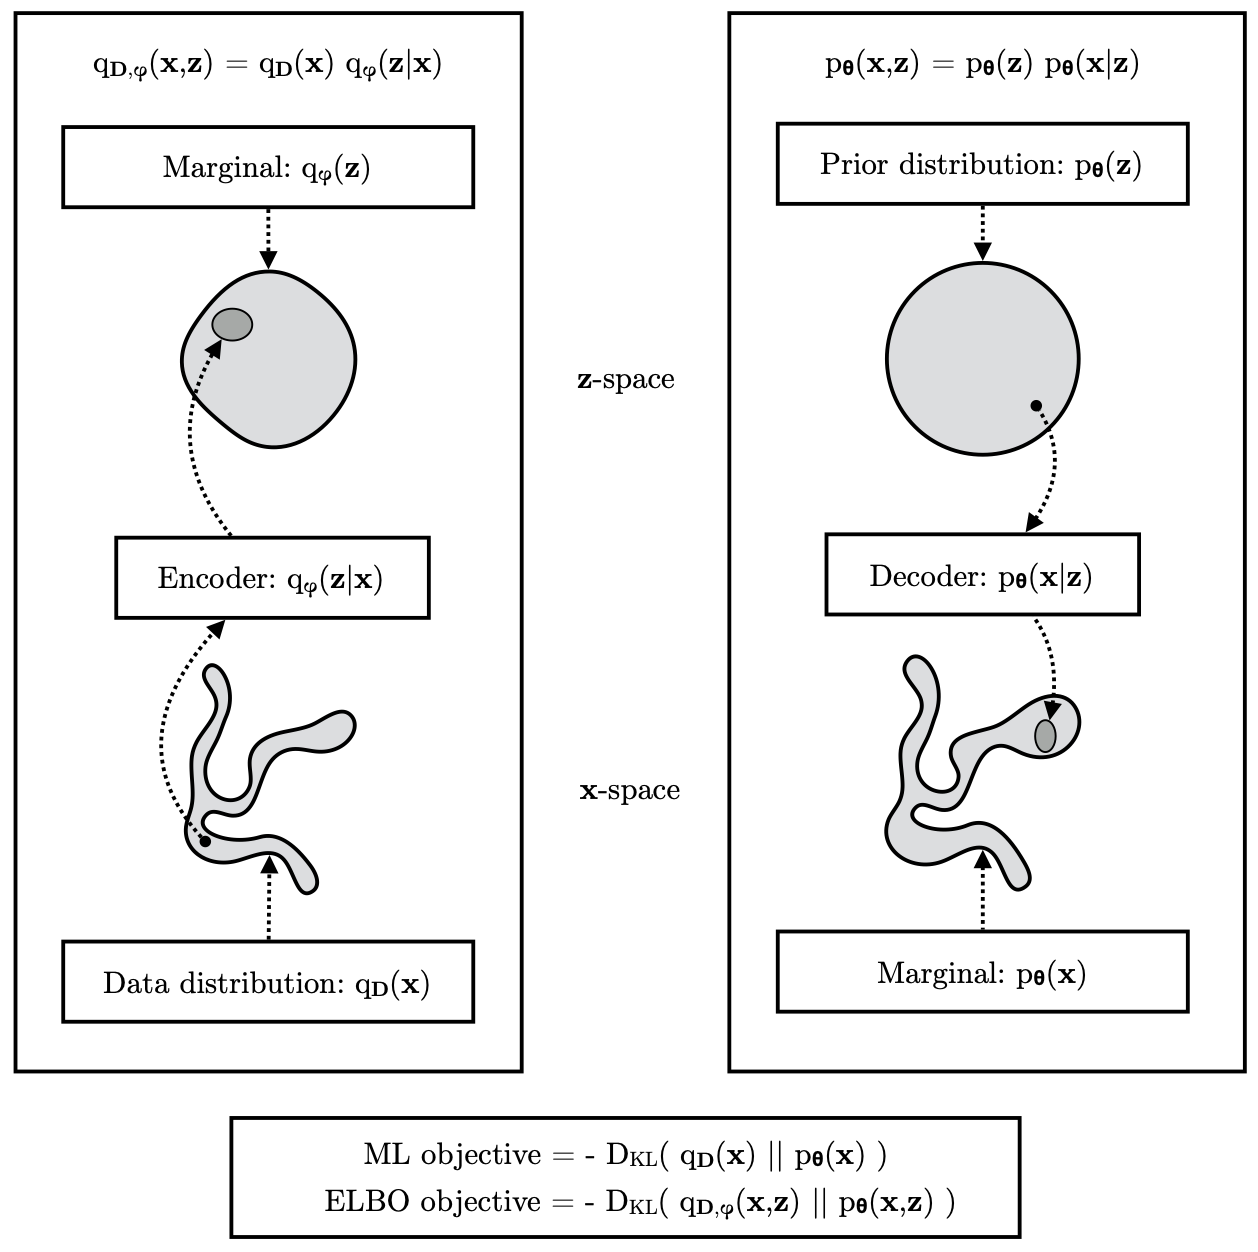

Целевую функцию максимального правдоподобия (ML) можно рассматривать как минимизацию $D_{\mathbb{KL}}\left(q_{\mathcal{D},\boldsymbol{\phi}}\left(\mathbf{x}\right)\parallel p_{\boldsymbol{\theta}}\left(\mathbf{x}\right)\right)$, в то время как целевую функцию ELBO можно рассматривать как минимизацию $D_{\mathbb{KL}}\left(q_{\mathcal{D},\boldsymbol{\phi}}\left(\mathbf{x},\mathbf{z}\right)\parallel p_{\boldsymbol{\theta}}\left(\mathbf{x},\mathbf{z}\right)\right)$, который сверху ограничивает $D_{\mathbb{KL}}\left(q_{\mathcal{D},\boldsymbol{\phi}}\left(\mathbf{x}\right)\parallel p_{\boldsymbol{\theta}}\left(\mathbf{x}\right)\right)$. Если идеальное обучение не возможно, то $p_{\boldsymbol{\theta}}\left(\mathbf{x},\mathbf{z}\right)$ обычно будет иметь более высокую дисперсию, чем $q_{\mathcal{D},\boldsymbol{\phi}}\left(\mathbf{x},\mathbf{z}\right)$, из-за направления KL-дивергенции.